# Lab: Convolutional NNs for CIFAR 10


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this lab, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over this dataset.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

**IMPORTANT NOTE:** In this notebook I show you how to speed up NN training using Graphical Processing Units (GPUs). To make sure you use a Google Colaboratory server equipped with a GPU, go to `Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

PRÁCTICA 3 PARTE 1 - REDES NEURONALES - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

DIEGO COLLADO MARTÍN - NIA: 100405606 

DIEGO LÓPEZ LÓPEZ - NIA: 100507210

In [6]:
# Veamos un pequeño conjunto de datos dentro del dataset 

from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [7]:
# Vemos como contamos con 10 clases. 

In [1]:


%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

d:\anaconda\envs\ids\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part I. Download CIFAR10 with `torchvision`

The code below will download the CIFAR10 dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [2]:
# Obtenemos el conjunto de entrenamiento y de test en batches de 64 imágenes. 

import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalizamos las tres dimensiones anchoxaltoxprofundidad

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [4]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([3, 32, 32])


Contamos con imágenes de 32x32 píxeles y 3 capas  al ser RGB

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

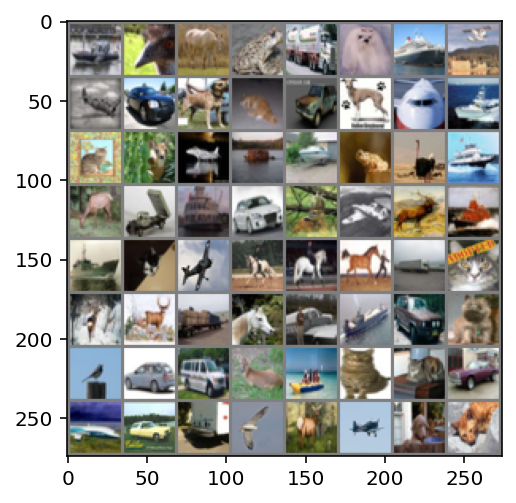

In [12]:
imshow(utils.make_grid(images)) 

> **Exercise:** Create a validation set using the 20% of train images

In [13]:

len(trainloader.dataset) 

50000

In [14]:
# YOUR CODE HERE
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 


trainloader.dataset.data = trainloader.dataset.data[:40000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:40000]

# El 20% restante se deja para validación (10k imágenes)
validloader.dataset.data = validloader.dataset.data[40000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[40000:]

In [15]:

print('Contamos con ' + str(len(trainloader.dataset)) + ' imágenes en el conjunto de entrenamiento')
print('Contamos con ' + str(len(validloader.dataset)) + ' imágenes en el conjunto de validación')

Contamos con 40000 imágenes en el conjunto de entrenamiento
Contamos con 10000 imágenes en el conjunto de validación


## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [16]:

Image(url= "https://ichi.pro/assets/images/max/724/0*H9_eGAtkQXJXtkoK")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [19]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0) 
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)

        
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layers

        self.linear1 = nn.Linear(400,120) #  (16*5*5 = 400)
        
        self.linear2 = nn.Linear(120,84)
        
        self.linear3 = nn.Linear(84,nlabels) 
    
        self.relu = nn.ReLU() 
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) 
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1,400) 
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [20]:
#YOUR CODE HERE

class Lenet5_extended(Lenet5):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Utilizamos el optimizador Adam
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               

        # A list to store the loss and validation evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = []
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                #out = self.forward(images.view(self.final_dim))

                out = self.forward(images) # en este caso no hacemos flatten ya que las convolucionales usan las imágenes al completo y cuando pasemos al MLP el flatten se hace desde la clase padre directamente.

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))


            # Validation Loss per epoch
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Compute output for input minibatch
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out, labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))   


            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))
        
    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = modelo.forward(images) # Pasamos las imágenes sin redimensionar por el mismo motivo que en el entrenamiento
        
                top_p, top_class = logprobs.topk(1, dim=1) # Cogemos la clase a la que más probabilidad le de mi modelo
                equals = (top_class == labels.view(images.shape[0], 1)) # Obtenemos el error dada la deducción del modelo
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

In [24]:

my_CNN = Lenet5_extended(dimx = 400, nlabels = 10, epochs= 5, lr = 1e-3)
my_CNN.train(trainloader)

Training loss after 0 epochs: 1.681144
Validation loss after 0 epochs: 1.469722
Training loss after 1 epochs: 1.387127
Validation loss after 1 epochs: 1.324832
Training loss after 2 epochs: 1.251654
Validation loss after 2 epochs: 1.221355
Training loss after 3 epochs: 1.164120
Validation loss after 3 epochs: 1.149410
Training loss after 4 epochs: 1.096606
Validation loss after 4 epochs: 1.138502


In [25]:

print('El modelo proporciona un acuraccy en el entrenamiento de: ' + str(my_CNN.acurracy_study(trainloader,my_CNN)))
print('El modelo proporciona un acuraccy en la validación de: ' + str(my_CNN.acurracy_study(validloader,my_CNN)))

El modelo proporciona un acuraccy en el entrenamiento de: 0.6291
El modelo proporciona un acuraccy en la validación de: 0.5977309


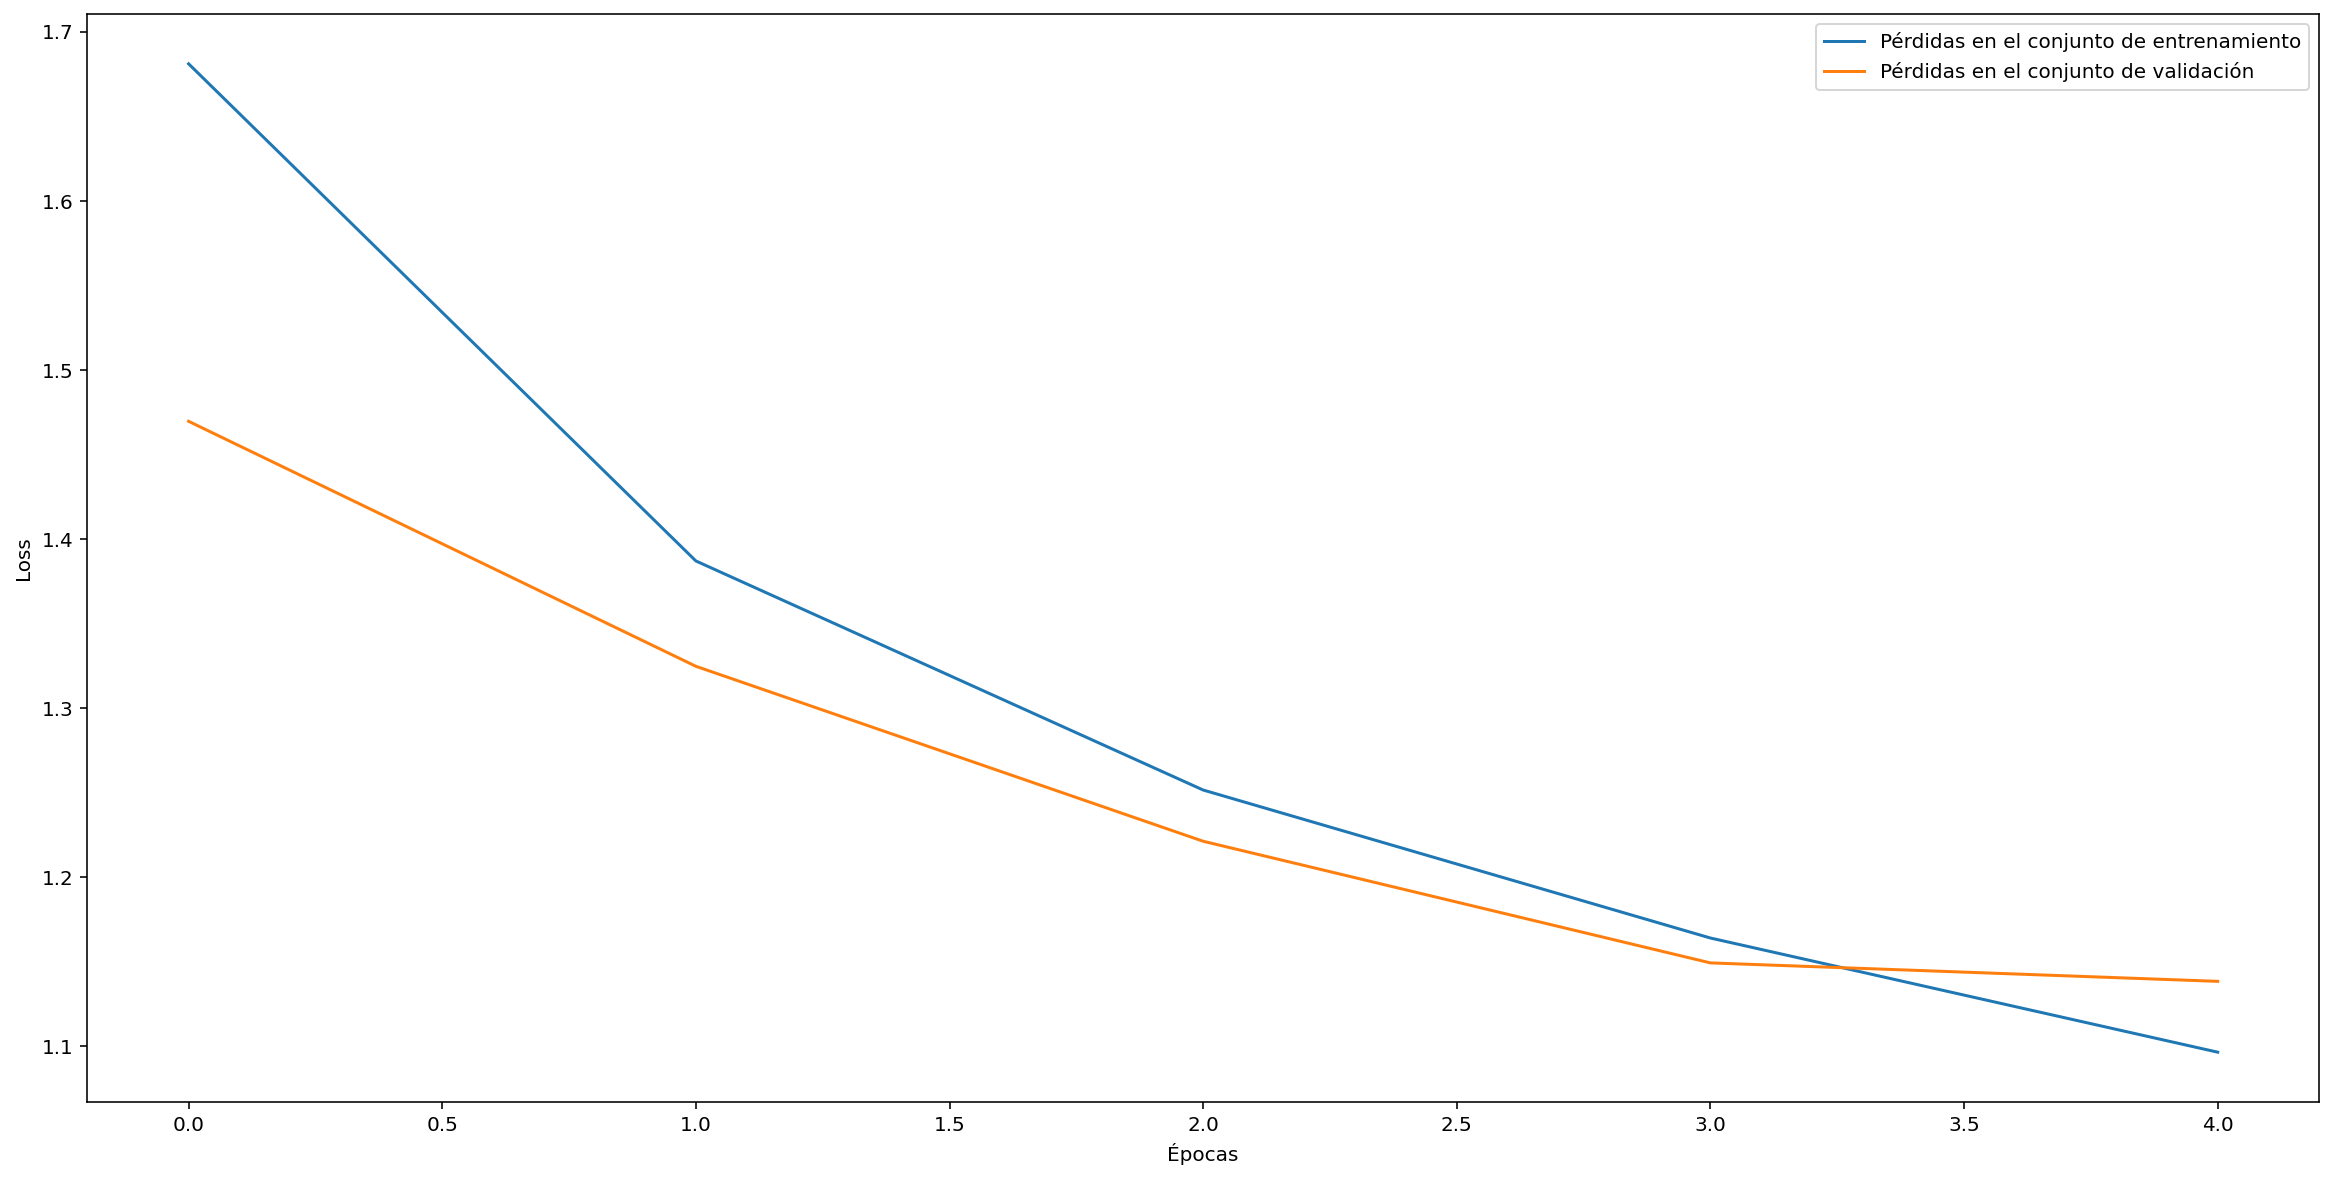

In [26]:
# Representamos dichas funciones gráficamente

fig, ax = plt.subplots(figsize = (20,10))
ax.set_xlabel('Épocas')
ax.set_ylabel('Loss')
ax.plot(my_CNN.loss_during_training, label = 'Pérdidas en el conjunto de entrenamiento')
ax.plot(my_CNN.valid_loss_during_training, label = 'Pérdidas en el conjunto de validación')
ax.legend()
fig.set_facecolor('white')

Aunque son solo 5 epocas se va viendo una posible estructura en la grafica que puede siginificar un posible overfitting. A partir de la época 3, si bien la función de pérdidas en el entrenamiento sigue bajando, la de validación empieza a mantenerse constante, concepto que da a entender que el módelo está adaptandose de más a los datos de entrenamiento y le empieza a costar generalizar sobre otros conjuntos.

## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**



In [27]:
class Lenet5_extended_GPU(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

        self.to(self.device) 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                
                #Get the output
                out = self.forward(images)

                #Compute the loss for the batch
                loss = self.criterion(out, labels)

                #Update the running loss
                running_loss += loss.item()
                
                #Compute gradients
                loss.backward()
                
                #Update network parameters
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                     
                    
                    # Compute output for input minibatch
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out, labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))
                
    def eval_performance(self,dataloader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) # Enviamos los tensores a la GPU
                probs = modelo.forward(images) # We use a log-softmax, so what we get are log-probabilities

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return ((accuracy/len(dataloader)).numpy().max())

In [28]:
# Creamos y entrenamos el modelo

my_CNN_GPU = Lenet5_extended_GPU(dimx=400,nlabels=10,epochs=5,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.697357, Validation loss: 1.478647
Epoch 1. Training loss: 1.411315, Validation loss: 1.354644
Epoch 2. Training loss: 1.292542, Validation loss: 1.271584
Epoch 3. Training loss: 1.204804, Validation loss: 1.222498
Epoch 4. Training loss: 1.142550, Validation loss: 1.179315


In [57]:

print('El modelo proporciona un acuraccy en el entrenamiento de: ' + str(my_CNN_GPU.eval_performance(trainloader,my_CNN_GPU)))
print('El modelo proporciona un acuraccy en la validación de: ' + str(my_CNN_GPU.eval_performance(validloader,my_CNN_GPU)))

El modelo proporciona un acuraccy en el entrenamiento de: 0.613675
El modelo proporciona un acuraccy en la validación de: 0.5800159


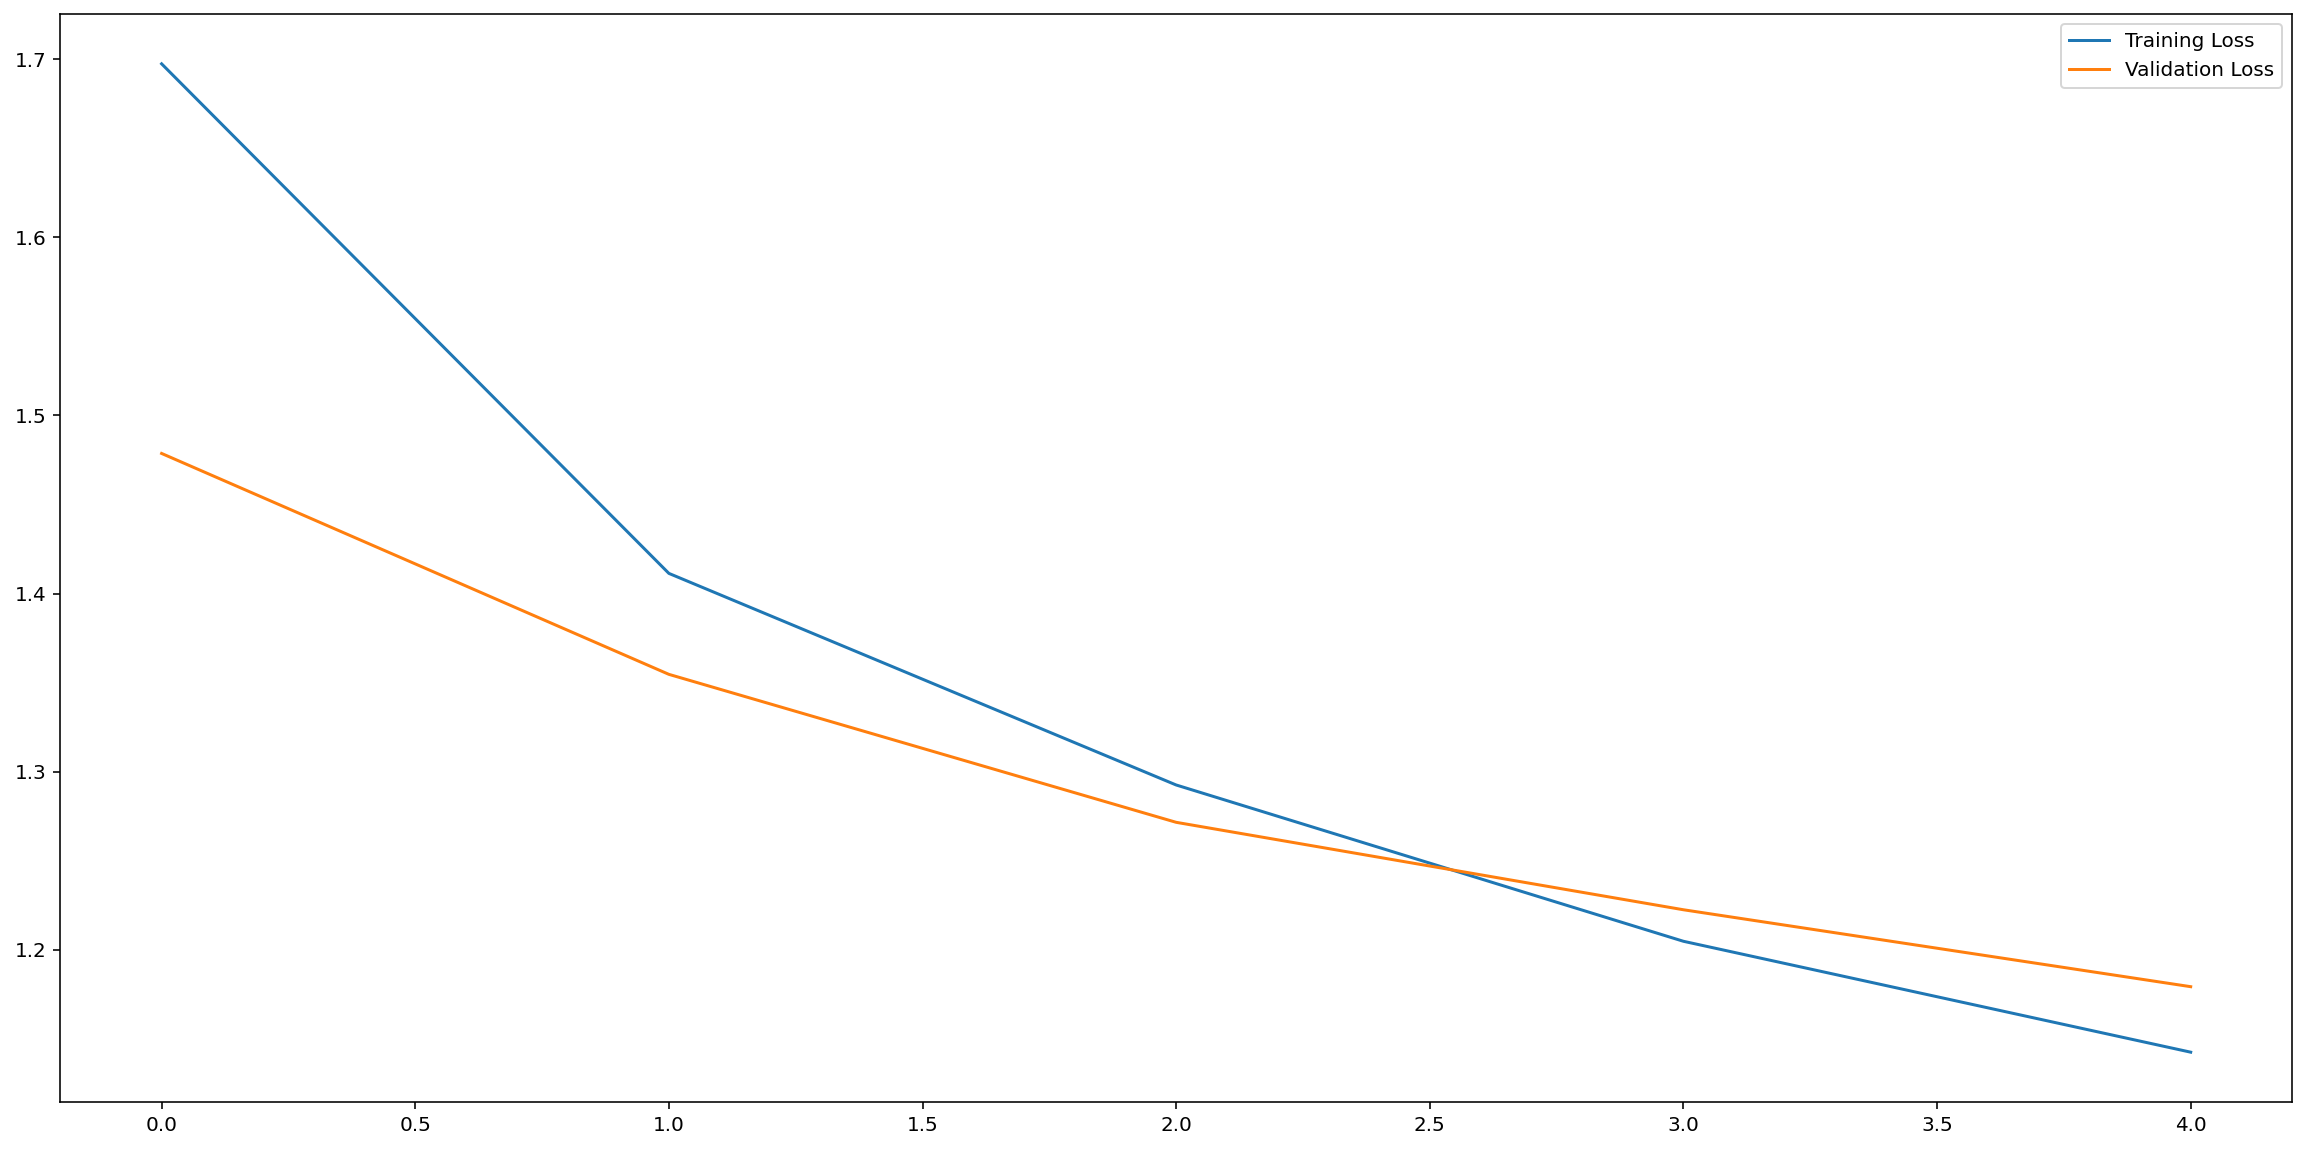

In [58]:

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
ax.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
ax.legend()
fig.set_facecolor('white')

With a GPU, you will see that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience, it is more efficient to include the dropout layers in between the final MLP layers, rather than in between convolutional layers. Note that once you include dropout, it wil take more epochs to converge. The more dropout layers, the more epochs typically you have to run. For this exercise, run at least 50 epochs.
> - Check the train/validation/test performance, plot the train and validation losses

In [47]:
#YOUR CODE HERE (Check CNN overfiting)

my_CNN_GPU = Lenet5_extended_GPU(dimx=400,nlabels=10,epochs=50,lr=1e-3)
my_CNN_GPU.trainloop(trainloader,validloader) 

Epoch 0. Training loss: 1.731590, Validation loss: 1.557503
Epoch 1. Training loss: 1.445287, Validation loss: 1.428899
Epoch 2. Training loss: 1.327057, Validation loss: 1.293994
Epoch 3. Training loss: 1.234522, Validation loss: 1.269698
Epoch 4. Training loss: 1.170391, Validation loss: 1.214984
Epoch 5. Training loss: 1.111638, Validation loss: 1.179342
Epoch 6. Training loss: 1.064289, Validation loss: 1.218459
Epoch 7. Training loss: 1.022760, Validation loss: 1.159712
Epoch 8. Training loss: 0.986820, Validation loss: 1.134181
Epoch 9. Training loss: 0.951355, Validation loss: 1.130811
Epoch 10. Training loss: 0.916442, Validation loss: 1.130525
Epoch 11. Training loss: 0.882636, Validation loss: 1.168703
Epoch 12. Training loss: 0.856810, Validation loss: 1.150677
Epoch 13. Training loss: 0.825796, Validation loss: 1.158143
Epoch 14. Training loss: 0.803251, Validation loss: 1.174259
Epoch 15. Training loss: 0.772859, Validation loss: 1.190881
Epoch 16. Training loss: 0.749848,

In [56]:

print('El modelo proporciona un acuraccy en el entrenamiento de: ' + str(my_CNN_GPU.eval_performance(trainloader,my_CNN_GPU)))
print('El modelo proporciona un acuraccy en la validación de: ' + str(my_CNN_GPU.eval_performance(validloader,my_CNN_GPU)))

El modelo proporciona un acuraccy en el entrenamiento de: 0.8987
El modelo proporciona un acuraccy en la validación de: 0.57434314


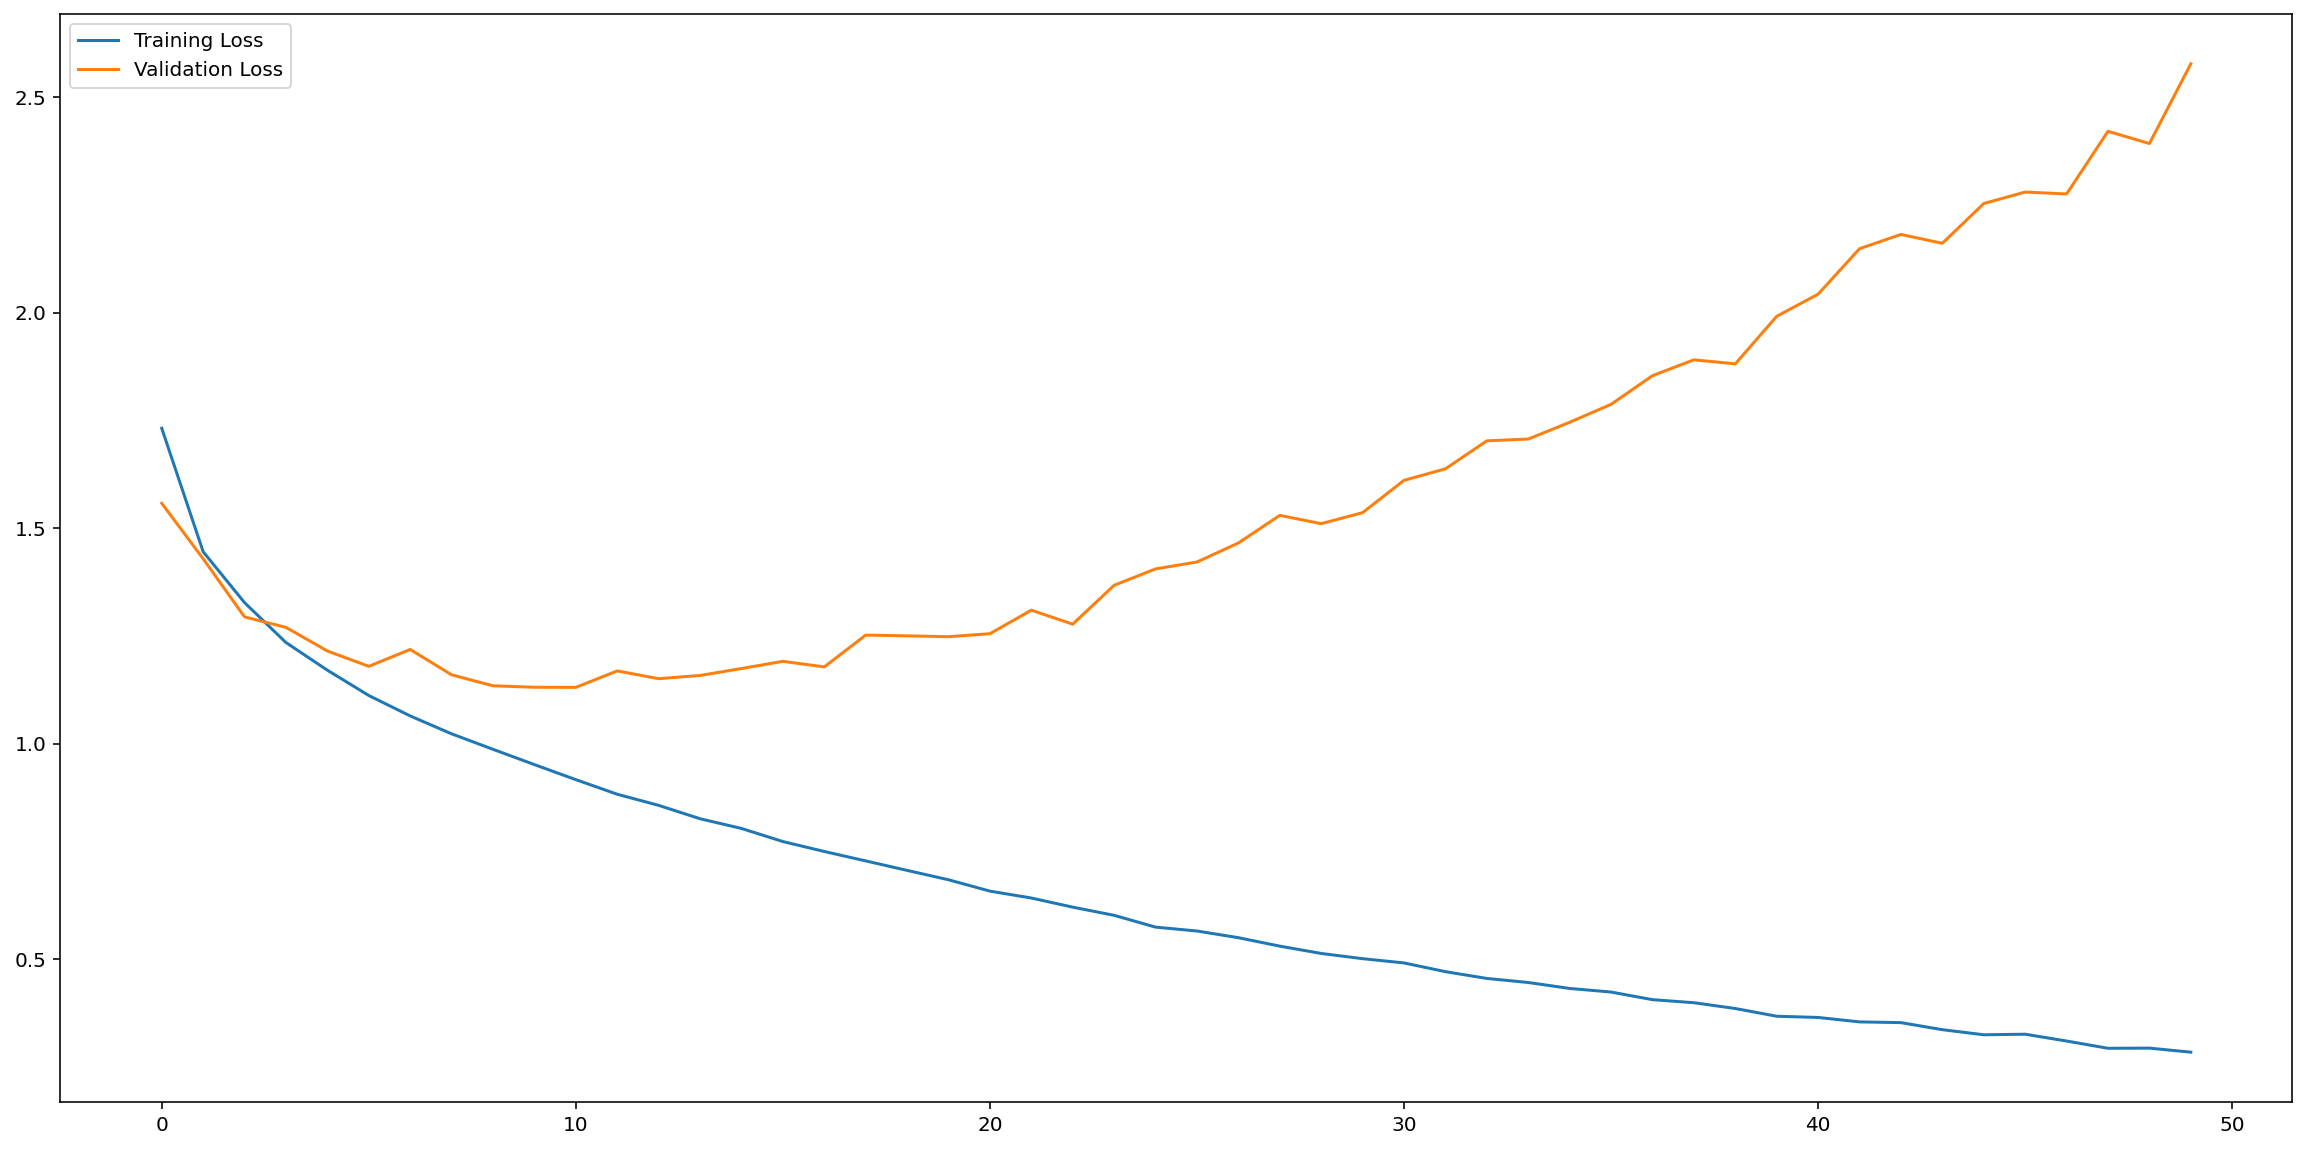

In [49]:
# Ploteamos ambas funciones gráficamente

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
ax.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
ax.legend()
fig.set_facecolor('white')



Si se observan los resultados del entrenamiento del modelo, hayuna señal clara de overfitting en la época 49. La pérdida de entrenamiento es bastante baja, solo 0.284253, pero en validación es mucho mayor, con un valor de 2.576999. Esto muestra que el modelo está yendo mucho mejor con los datos de entrenamiento que con los de validación, lo cual no es ideal. En términos de precisión, también hay una gran diferencia: un 90% en entrenamiento frente a un 58% en validación.

El problema se hace más evidente cuando miras la grafica del proceso de entrenamiento. A partir de la quinta época más o menos, hay un cambio notable: la línea de la pérdida de validación empieza a subir en lugar de bajar, mientras que la de entrenamiento continua bajando. Esto es una señal de que el modelo está aprendiendo de memoria los datos de entrenamiento, pero no está generalizando bien a nuevos datos, que es justo cuando decimos que hay un overfitting serio.

In [31]:
#YOUR CODE HERE (Regularize the network)

class Lenet5_dropout(nn.Module):
    def __init__(self,dimx,nlabels,p_dropout): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)

        
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2) 

        # Linear layers

       

        self.linear1 = nn.Linear(400,120) # (16*5*5 = 400)
        
        self.linear2 = nn.Linear(120,84)
        
        self.linear3 = nn.Linear(84,nlabels)
    
        self.relu = nn.ReLU() 
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 

        self.dropout = nn.Dropout(p_dropout) # Introducimos el droput c
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) 
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1,400) 
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.linear3(x)
        x = self.logsoftmax(x)
        return x

In [32]:
class Lenet5_extended_GPU_dropout(Lenet5_dropout):
    
    #Your code here
    
    def __init__(self,dimx,nlabels,p_dropout,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels,p_dropout)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Para implementar CUDA

        self.to(self.device) # Enviamos el modelo a la GPU
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            self.train()

            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                
                #Get the output
                out = self.forward(images)

                #Compute the loss for the batch
                loss = self.criterion(out, labels)

                #Update the running loss
                running_loss += loss.item()
                
                #Compute gradients
                loss.backward()
                
                #Update network parameters
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                self.eval() 

                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device)                     
                    
                    # Compute output for input minibatch
                    out = self.forward(images)

                    #Your code here
                    loss = self.criterion(out, labels)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            if(e % 1 == 0): # Every epoch

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))
                
    def eval_performance(self,dataloader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.eval()
            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                probs = modelo.forward(images) # We use a log-softmax, so what we get are log-probabilities

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return ((accuracy/len(dataloader)).numpy().max())

Empezamos aplicando dropout con una probabilidad de 30% 

In [33]:
my_CNN_GPU_dropout = Lenet5_extended_GPU_dropout(dimx=400,nlabels=10,epochs=50,lr=1e-3,p_dropout=0.3)
my_CNN_GPU_dropout.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.797806, Validation loss: 1.504326
Epoch 1. Training loss: 1.499181, Validation loss: 1.384185
Epoch 2. Training loss: 1.392466, Validation loss: 1.301097
Epoch 3. Training loss: 1.321316, Validation loss: 1.270682
Epoch 4. Training loss: 1.265067, Validation loss: 1.203906
Epoch 5. Training loss: 1.219028, Validation loss: 1.184421
Epoch 6. Training loss: 1.184910, Validation loss: 1.158721
Epoch 7. Training loss: 1.154754, Validation loss: 1.142200
Epoch 8. Training loss: 1.123585, Validation loss: 1.142917
Epoch 9. Training loss: 1.105801, Validation loss: 1.128605
Epoch 10. Training loss: 1.082066, Validation loss: 1.121392
Epoch 11. Training loss: 1.062070, Validation loss: 1.116566
Epoch 12. Training loss: 1.045582, Validation loss: 1.090109
Epoch 13. Training loss: 1.033321, Validation loss: 1.110640
Epoch 14. Training loss: 1.018723, Validation loss: 1.129731
Epoch 15. Training loss: 1.007732, Validation loss: 1.096658
Epoch 16. Training loss: 0.987113,

In [34]:

print('El modelo proporciona un acuraccy en el entrenamiento de: ' + str(my_CNN_GPU_dropout.eval_performance(trainloader,my_CNN_GPU_dropout)))
print('El modelo proporciona un acuraccy en la validación de: ' + str(my_CNN_GPU_dropout.eval_performance(validloader,my_CNN_GPU_dropout)))

El modelo proporciona un acuraccy en el entrenamiento de: 0.807625
El modelo proporciona un acuraccy en la validación de: 0.62181526


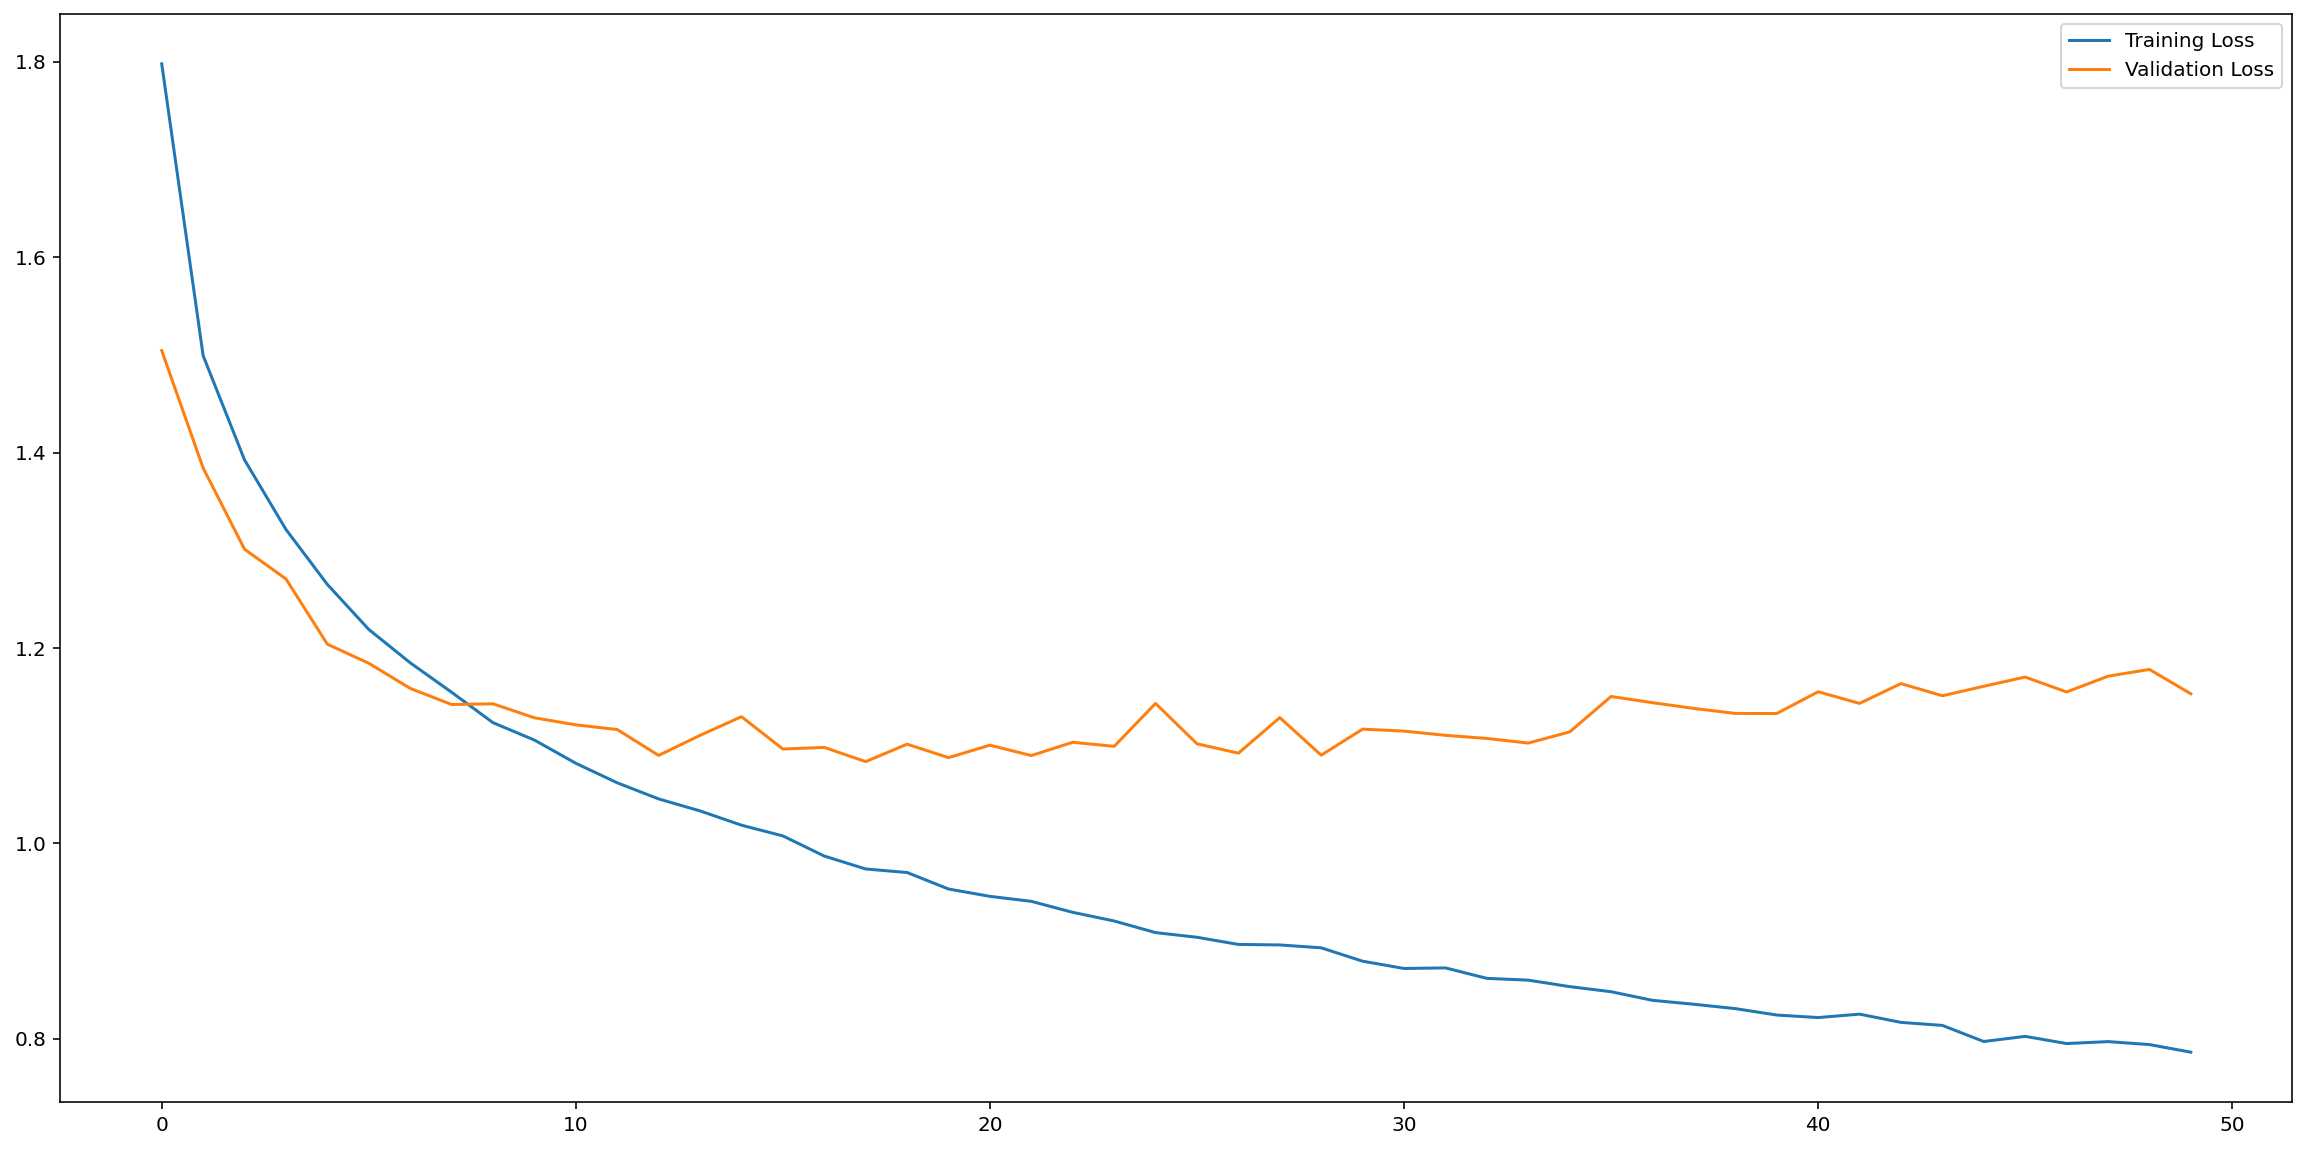

In [35]:

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CNN_GPU_dropout.loss_during_training,label='Training Loss')
ax.plot(my_CNN_GPU_dropout.valid_loss_during_training,label='Validation Loss')
ax.legend()
fig.set_facecolor('white')

Tanto en las cifras de entrenamiento y precisión como en los gráficos, se aprecia que gracias al uso del dropout hemos logrado disminuir el overfitting. A pesar de este avance, aún no es suficiente, y es necesario implementar una técnica de "early-stopping". Para determinar el punto exacto en el que deberíamos detener el entrenamiento, conviene hacer un análisis más detallado haciendo un acercamiento en la gráfica a las primeras 20 épocas. 

(0.0, 20.0)

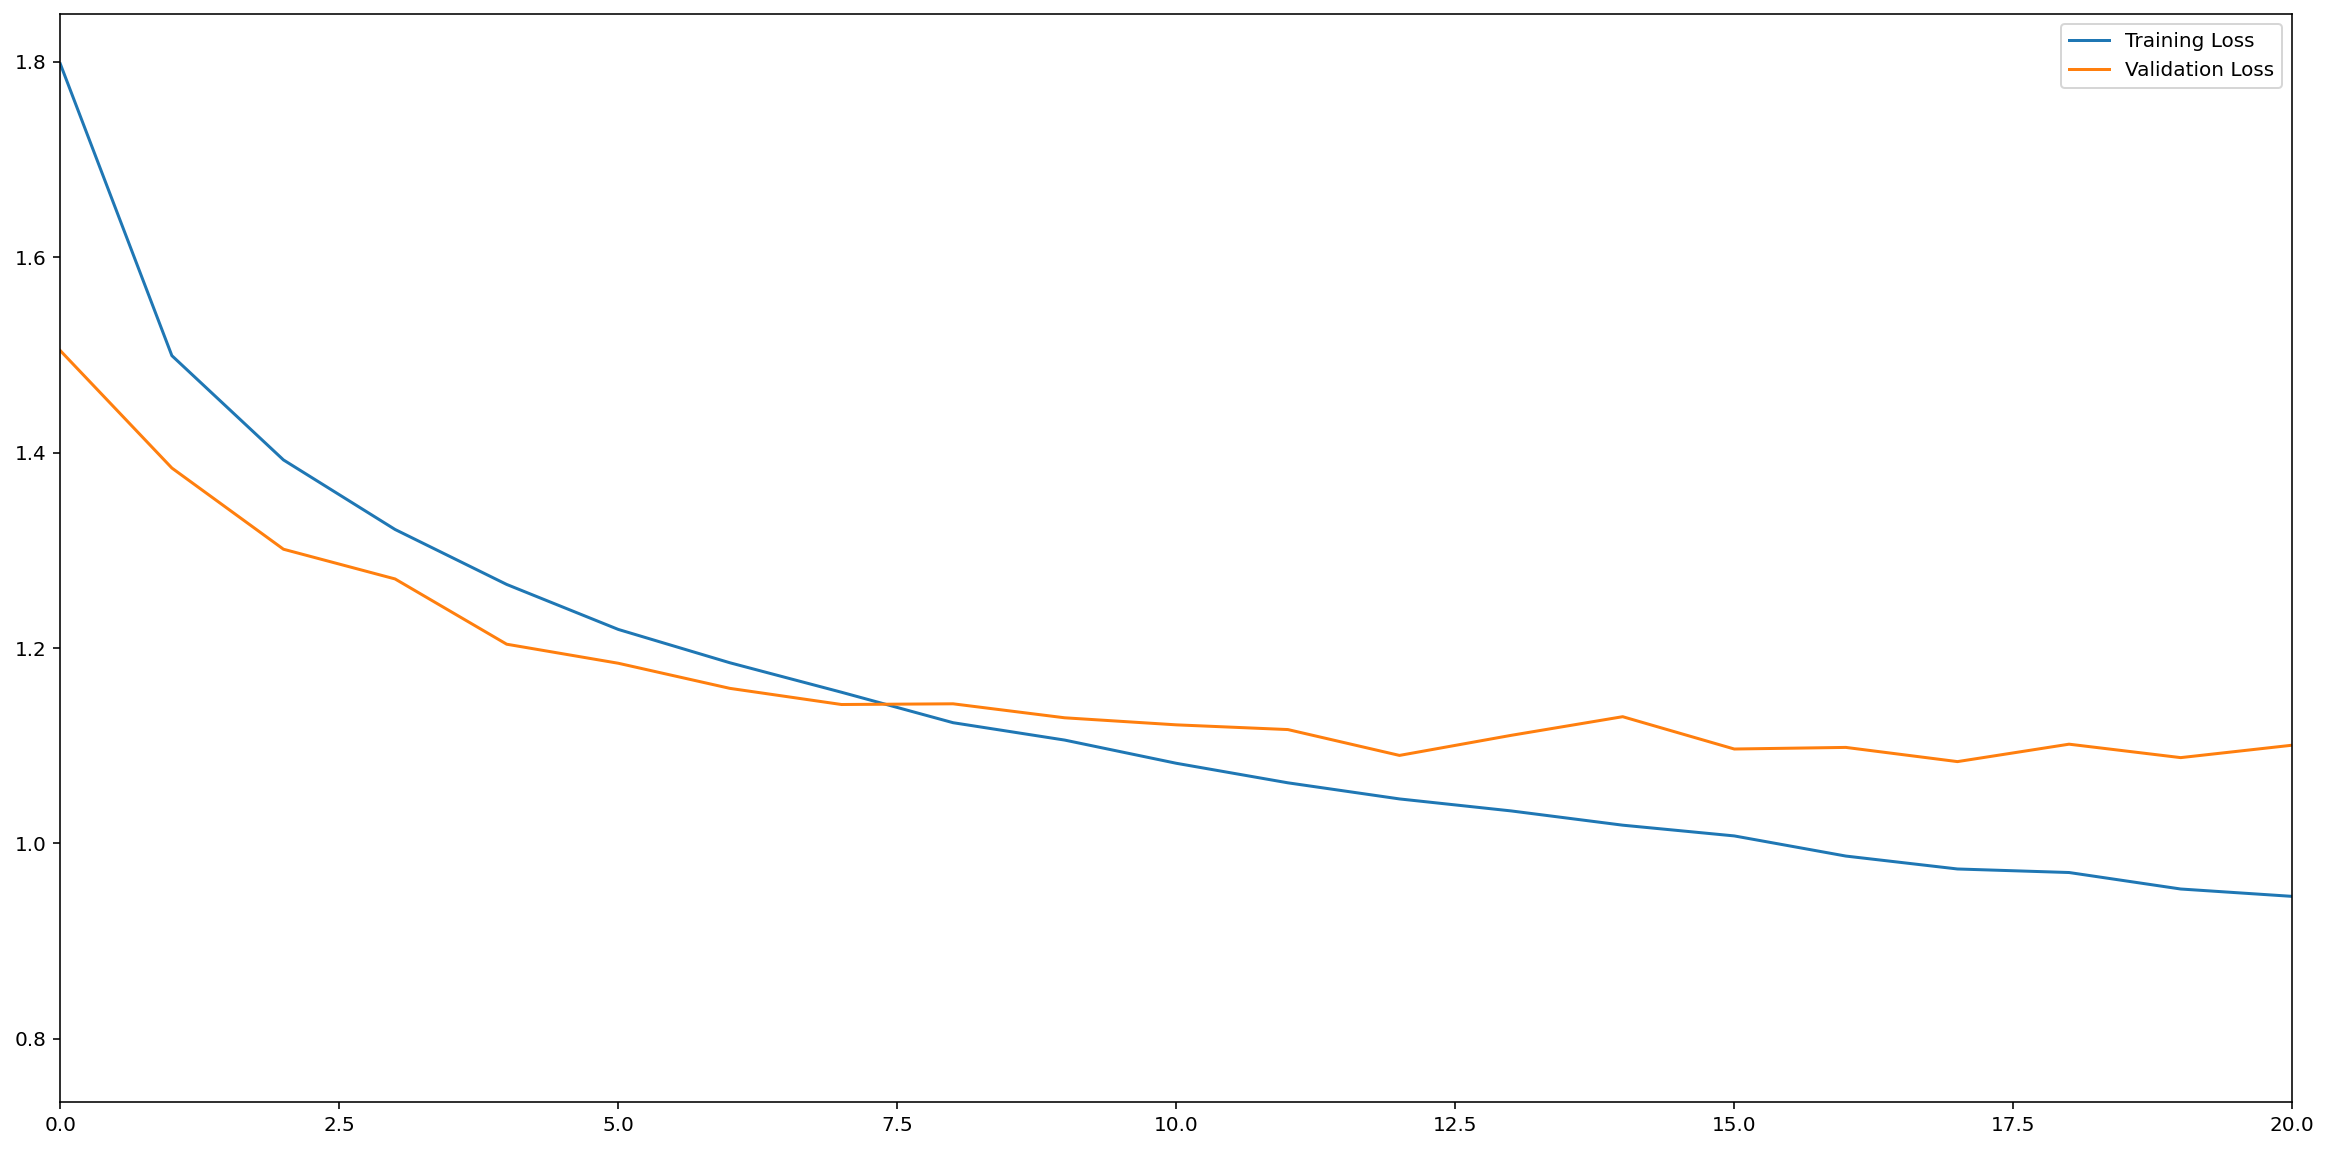

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CNN_GPU_dropout.loss_during_training,label='Training Loss')
ax.plot(my_CNN_GPU_dropout.valid_loss_during_training,label='Validation Loss')
ax.legend()
fig.set_facecolor('white')
ax.set_xlim(left = 0, right = 20)

Parece que en la epoca 15 alcanza el mejor valor

In [56]:

my_CNN_GPU_dropout_and_earlystopping = Lenet5_extended_GPU_dropout(dimx=400,nlabels=10,epochs=15,lr=1e-3,p_dropout=0.3)
my_CNN_GPU_dropout_and_earlystopping.trainloop(trainloader,validloader)

Epoch 0. Training loss: 1.788735, Validation loss: 1.531643
Epoch 1. Training loss: 1.506053, Validation loss: 1.379061
Epoch 2. Training loss: 1.399525, Validation loss: 1.315081
Epoch 3. Training loss: 1.327648, Validation loss: 1.250056
Epoch 4. Training loss: 1.271024, Validation loss: 1.223619
Epoch 5. Training loss: 1.233147, Validation loss: 1.171935
Epoch 6. Training loss: 1.194597, Validation loss: 1.148867
Epoch 7. Training loss: 1.158863, Validation loss: 1.126026
Epoch 8. Training loss: 1.134257, Validation loss: 1.120197
Epoch 9. Training loss: 1.111751, Validation loss: 1.093724
Epoch 10. Training loss: 1.090172, Validation loss: 1.098421
Epoch 11. Training loss: 1.072051, Validation loss: 1.068338
Epoch 12. Training loss: 1.052641, Validation loss: 1.070036
Epoch 13. Training loss: 1.033062, Validation loss: 1.073858
Epoch 14. Training loss: 1.021666, Validation loss: 1.078485


In [38]:

print('El modelo proporciona un acuraccy en el entrenamiento de: ' + str(my_CNN_GPU_dropout_and_earlystopping.eval_performance(trainloader,my_CNN_GPU_dropout_and_earlystopping)))
print('El modelo proporciona un acuraccy en la validación de: ' + str(my_CNN_GPU_dropout_and_earlystopping.eval_performance(validloader,my_CNN_GPU_dropout_and_earlystopping)))

El modelo proporciona un acuraccy en el entrenamiento de: 0.7046
El modelo proporciona un acuraccy en la validación de: 0.6237062


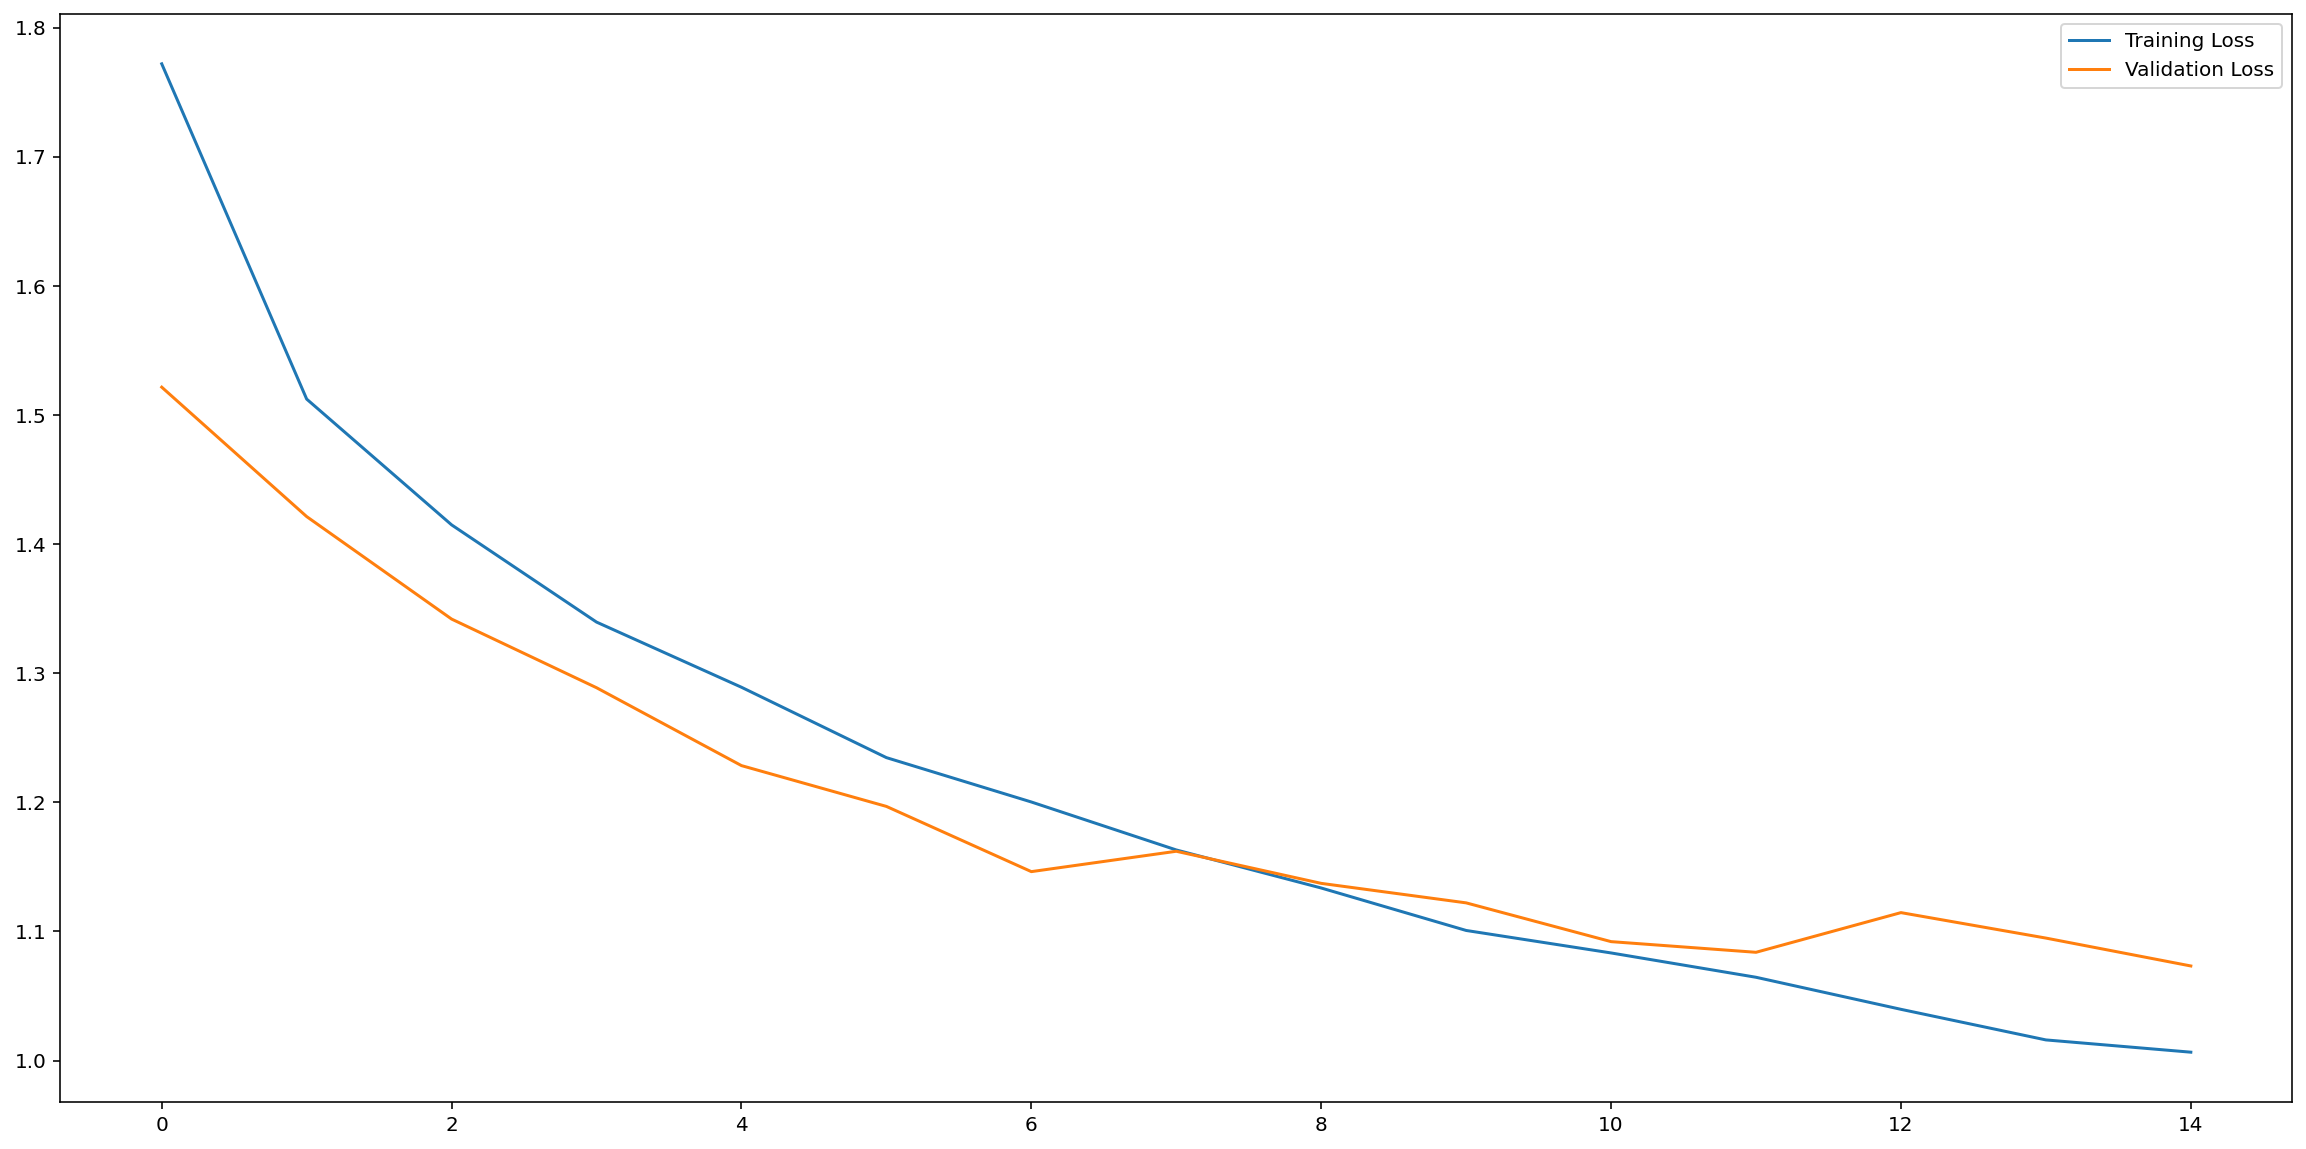

In [39]:
# Ploteamos ambas funciones gráficamente

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CNN_GPU_dropout_and_earlystopping.loss_during_training,label='Training Loss')
ax.plot(my_CNN_GPU_dropout_and_earlystopping.valid_loss_during_training,label='Validation Loss')
ax.legend()
fig.set_facecolor('white')

Hemos logrado una reducción significativa del overfitting. Originalmente, al entrenar la red por 50 épocas, había una gran discrepancia entre la precisión del entrenamiento y del test, pero esa brecha se ha cerrado a un 18% después de introducir un dropout con una probabilidad del 30%. Con la adición del early-stopping, esta diferencia se ha comprimido aún más hasta un 8%.

Los datos de la última época de entrenamiento son muy reveladores: en la Epoch 14, la pérdida de entrenamiento fue de 1.006495 y la de validación fue de 1.073280, mostrando una clara mejora en la capacidad del modelo de generalizar a nuevos datos.


Al observar las gráficas, se puede notar que el overfitting se ha minimizado enormemente en comparación con las gráficas previas, donde la diferencia entre la pérdida de entrenamiento y validación era mucho más marcada.

### Train an MLP to compare the performance (Optional)

Train an MLP with 3-4 layers to compare the performance. Take into account that the input image has three color maps. If you stuck it into a vector, then the input dimension is 3x32x32 = 3072. An alternative is to compute the average between the three. Alternatively, you could use only one color map, or the average between three of them ...

Creamos el MLP con dropout y extendemos la clase tal y como haciamos en las anteriores prácticas

In [40]:
#YOUR CODE HERE

class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)

        self.output4 = nn.Linear(hidden3, nlabels) # Como nos piden 4 capas, añadimos una nueva respecto al MLP de la práctica anterior
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)    

        self.dropout = nn.Dropout(p_dropout) # Introducimos el droput con una probabilidad de 0.2                                                         
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = x.view(-1,3072) # Aplico en este punto el flatten para evitar hacerlo después. Mis imágenes de entrada son RGB de 32x32, por lo que a las capas densas entrará un vector de 32x32x3=3072
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x) # introducimos tras la función de activación un droput para desactivar de forma aleatoria ciertas "hidden units" 
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x) # A la salida se le aplica la logsoftmax para la clasificación multiclase
        return x

In [41]:
#YOUR CODE HERE

class MLPdrop_extended(MLPdrop):
    # Todo es igual que el regresor logístico multiclase pero añadiendo el número de las neuronas de las capas ocultas
    # Añadimos la dimensión de la capa extra con la que contamos
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,p_dropout)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # Lista que guarda la evolución de la función de coste en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            self.train() # ya que vamos a entrenar el modelo y queremos aplicar dropout

            for images, labels in trainloader:             
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images) # en todos los forward de aquí obviamos el flatten ya que se hace dentro del propio forward 

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): # de esta forma ahorra en coste computacional

                self.eval() # desactivamos el droput para el test del conjunto de evaluación

                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val)
                    validation_loss += self.criterion(out_val, labels_val)
                # de esta forma, en cada época, estudiamos el valor de la función de coste sobre todo el conjunto de validación
                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader)) # actualizamos dicho valor en la época correspondiente

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1])) # ploteamos el valor de la función de coste sobre el conjunto de valdación en cada época
                print('')

    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            self.eval()
            for images,labels in loader:
        
                logprobs = modelo.forward(images) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

Aplicamos 50 épocas con dropout de 30% para hacerlo igual que con las CNN y poder comparar bien.

In [45]:

my_MLP_dropout = MLPdrop_extended(dimx=3072, hidden1=128, hidden2=64, hidden3=32, nlabels=10, p_dropout=0.3 , epochs=50, lr=0.001)
my_MLP_dropout.trainloop(trainloader,validloader)

Training loss after 0 epochs: 1.929583
Validation loss after 0 epochs: 1.727058

Training loss after 1 epochs: 1.770504
Validation loss after 1 epochs: 1.641048

Training loss after 2 epochs: 1.710258
Validation loss after 2 epochs: 1.602806

Training loss after 3 epochs: 1.665149
Validation loss after 3 epochs: 1.573954

Training loss after 4 epochs: 1.626688
Validation loss after 4 epochs: 1.535452

Training loss after 5 epochs: 1.602153
Validation loss after 5 epochs: 1.523969

Training loss after 6 epochs: 1.579705
Validation loss after 6 epochs: 1.504309

Training loss after 7 epochs: 1.566475
Validation loss after 7 epochs: 1.482452

Training loss after 8 epochs: 1.545384
Validation loss after 8 epochs: 1.476188

Training loss after 9 epochs: 1.525843
Validation loss after 9 epochs: 1.473844

Training loss after 10 epochs: 1.518145
Validation loss after 10 epochs: 1.455632

Training loss after 11 epochs: 1.500650
Validation loss after 11 epochs: 1.441427

Training loss after 12 e

In [46]:

print('El modelo proporciona un acuraccy en el entrenamiento de: ' + str(my_MLP_dropout.acurracy_study(trainloader,my_MLP_dropout)))
print('El modelo proporciona un acuraccy en la validación de: ' + str(my_MLP_dropout.acurracy_study(validloader,my_MLP_dropout)))

El modelo proporciona un acuraccy en el entrenamiento de: 0.6468
El modelo proporciona un acuraccy en la validación de: 0.5065685


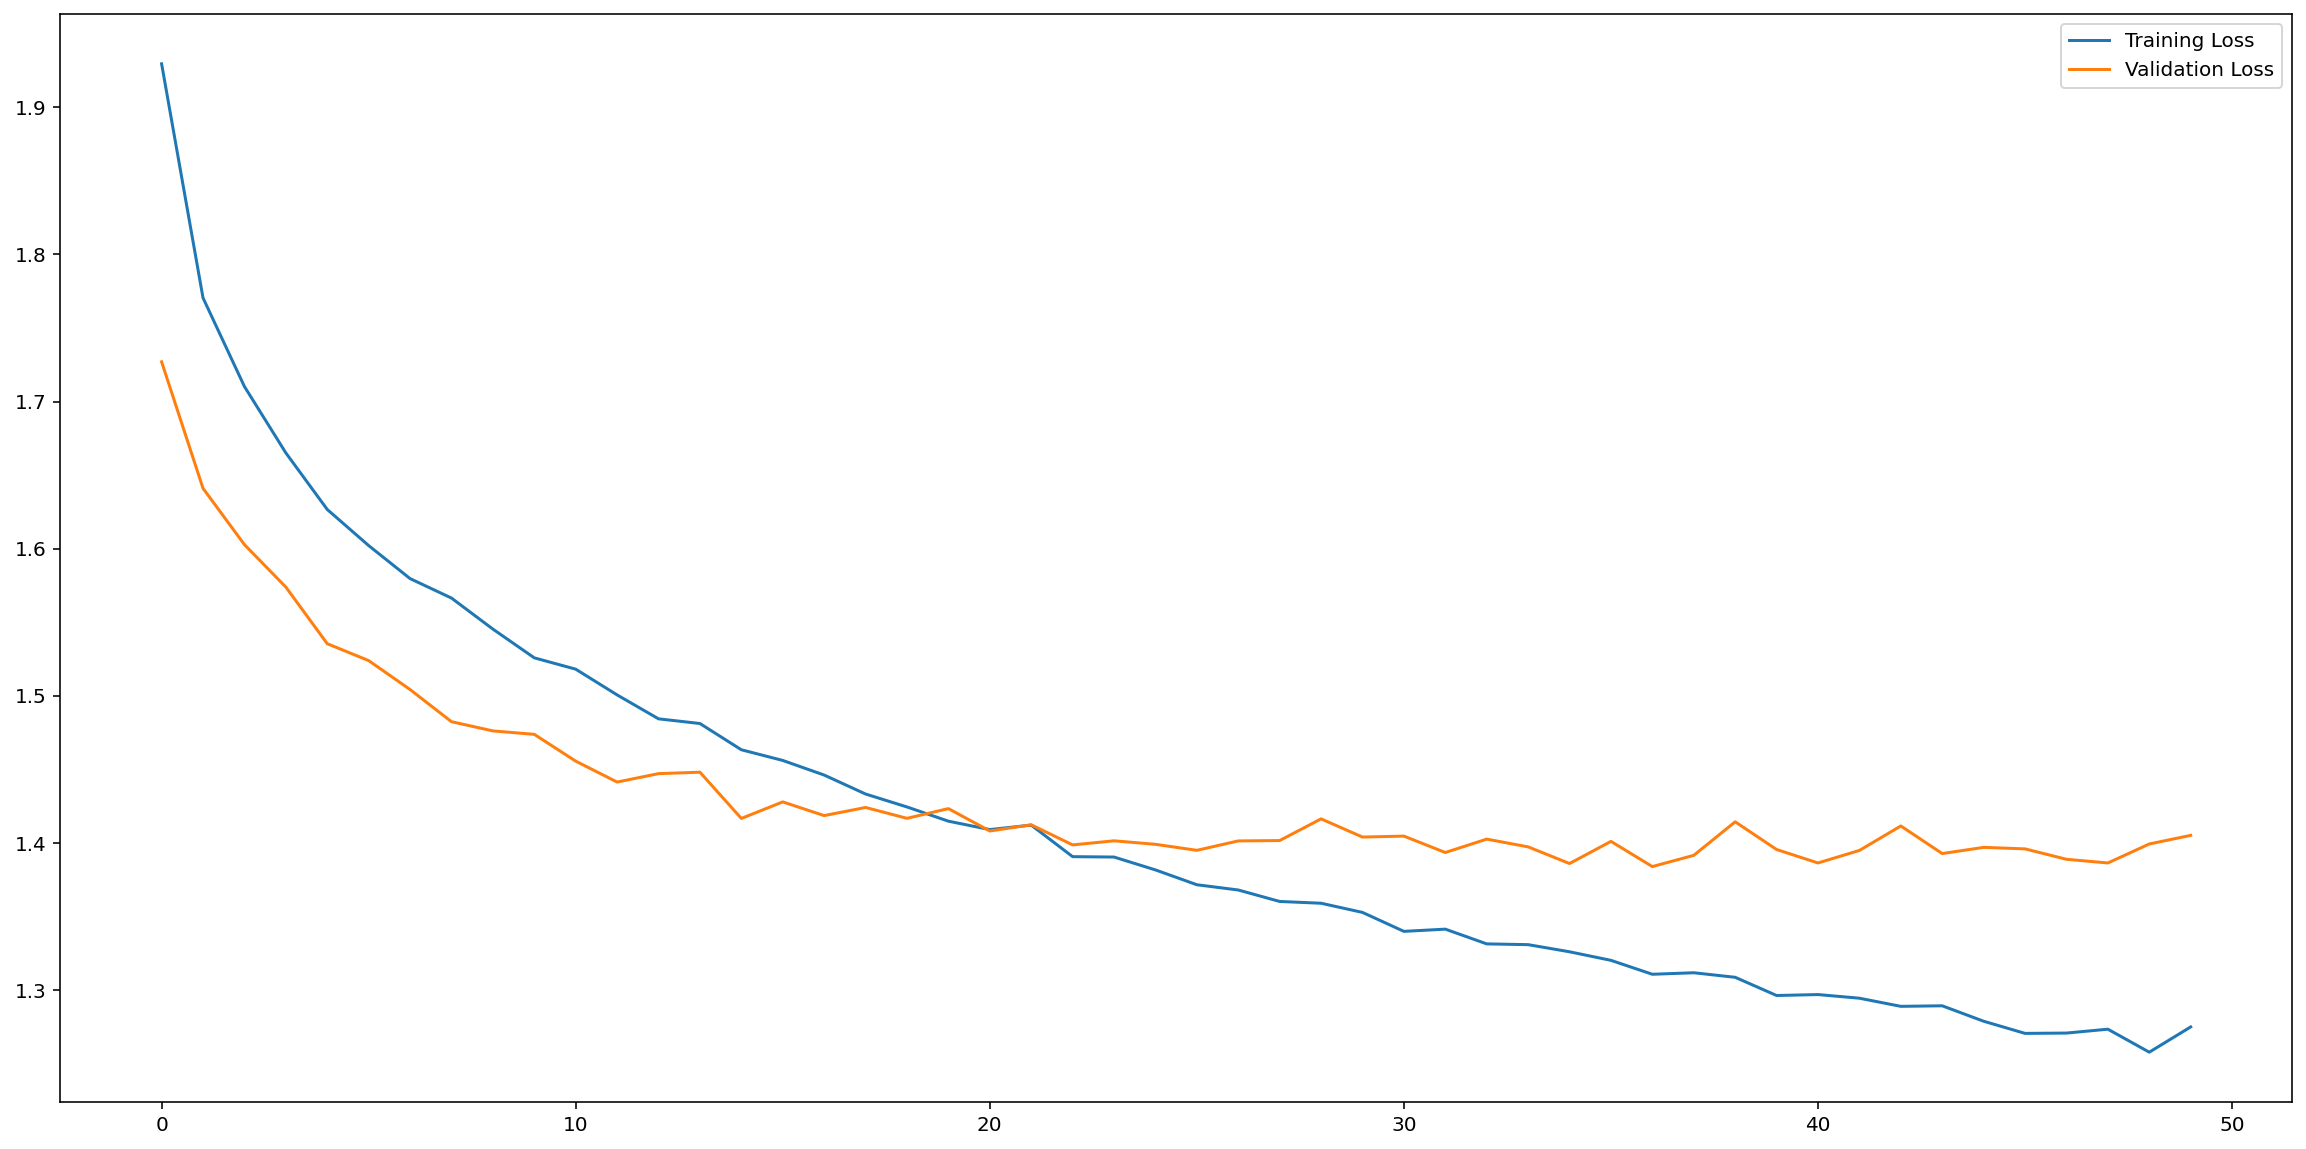

In [47]:


fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_MLP_dropout.loss_during_training,label='Training Loss')
ax.plot(my_MLP_dropout.valid_loss_during_training,label='Validation Loss')
ax.legend()
fig.set_facecolor('white')

Veamos donde aplicar "early-stopping" haciendo un zoom sobre la imagen.

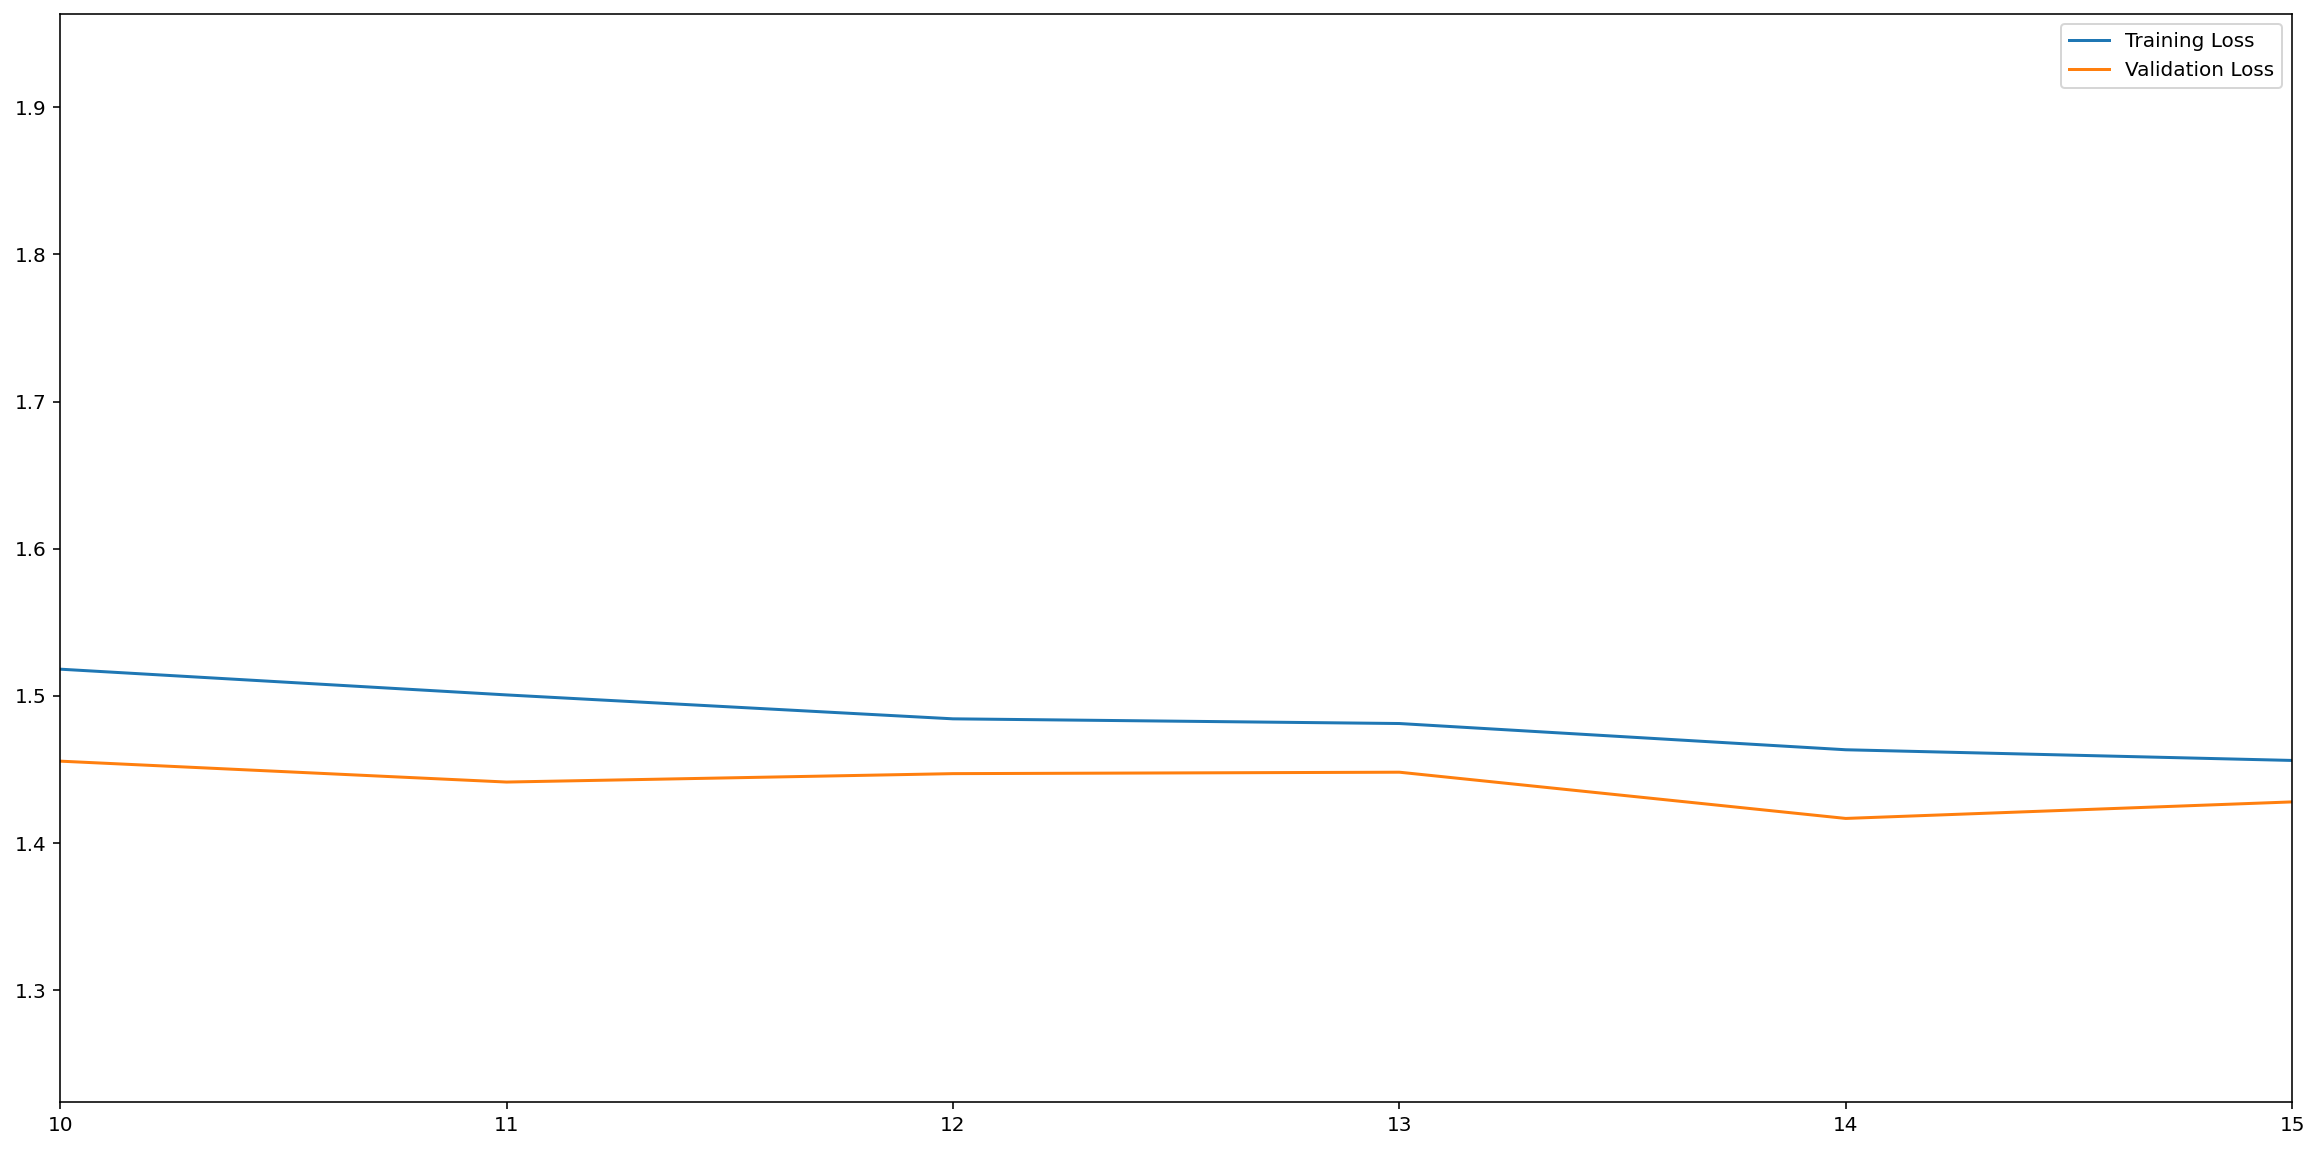

In [48]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_MLP_dropout.loss_during_training,label='Training Loss')
ax.plot(my_MLP_dropout.valid_loss_during_training,label='Validation Loss')
ax.legend()
ax.set_xlim(left = 10, right = 15)
fig.set_facecolor('white')

Observando la gráfica, vemos como sobre la época 14 debemos parar para obtener el mínimo del conjunto de validación. 

In [49]:
# Creamos y entrenamos el modelo con 50 épocas.
my_MLP_dropout_estop = MLPdrop_extended(dimx=3072, hidden1=128, hidden2=64, hidden3=32, nlabels=10, p_dropout=0.3 , epochs=14, lr=1e-3)
my_MLP_dropout_estop.trainloop(trainloader,validloader)

Training loss after 0 epochs: 1.914998
Validation loss after 0 epochs: 1.706408

Training loss after 1 epochs: 1.764285
Validation loss after 1 epochs: 1.638562

Training loss after 2 epochs: 1.707514
Validation loss after 2 epochs: 1.597678

Training loss after 3 epochs: 1.665768
Validation loss after 3 epochs: 1.562134

Training loss after 4 epochs: 1.632355
Validation loss after 4 epochs: 1.543463

Training loss after 5 epochs: 1.602176
Validation loss after 5 epochs: 1.519095

Training loss after 6 epochs: 1.579142
Validation loss after 6 epochs: 1.508236

Training loss after 7 epochs: 1.554495
Validation loss after 7 epochs: 1.493782

Training loss after 8 epochs: 1.540824
Validation loss after 8 epochs: 1.475744

Training loss after 9 epochs: 1.525493
Validation loss after 9 epochs: 1.461337

Training loss after 10 epochs: 1.504030
Validation loss after 10 epochs: 1.442857

Training loss after 11 epochs: 1.499389
Validation loss after 11 epochs: 1.446290

Training loss after 12 e

In [50]:

print('El modelo proporciona un acuraccy en el entrenamiento de: ' + str(my_MLP_dropout_estop.acurracy_study(trainloader,my_MLP_dropout_estop)))
print('El modelo proporciona un acuraccy en la validación de: ' + str(my_MLP_dropout_estop.acurracy_study(validloader,my_MLP_dropout_estop)))

El modelo proporciona un acuraccy en el entrenamiento de: 0.5556
El modelo proporciona un acuraccy en la validación de: 0.49621814


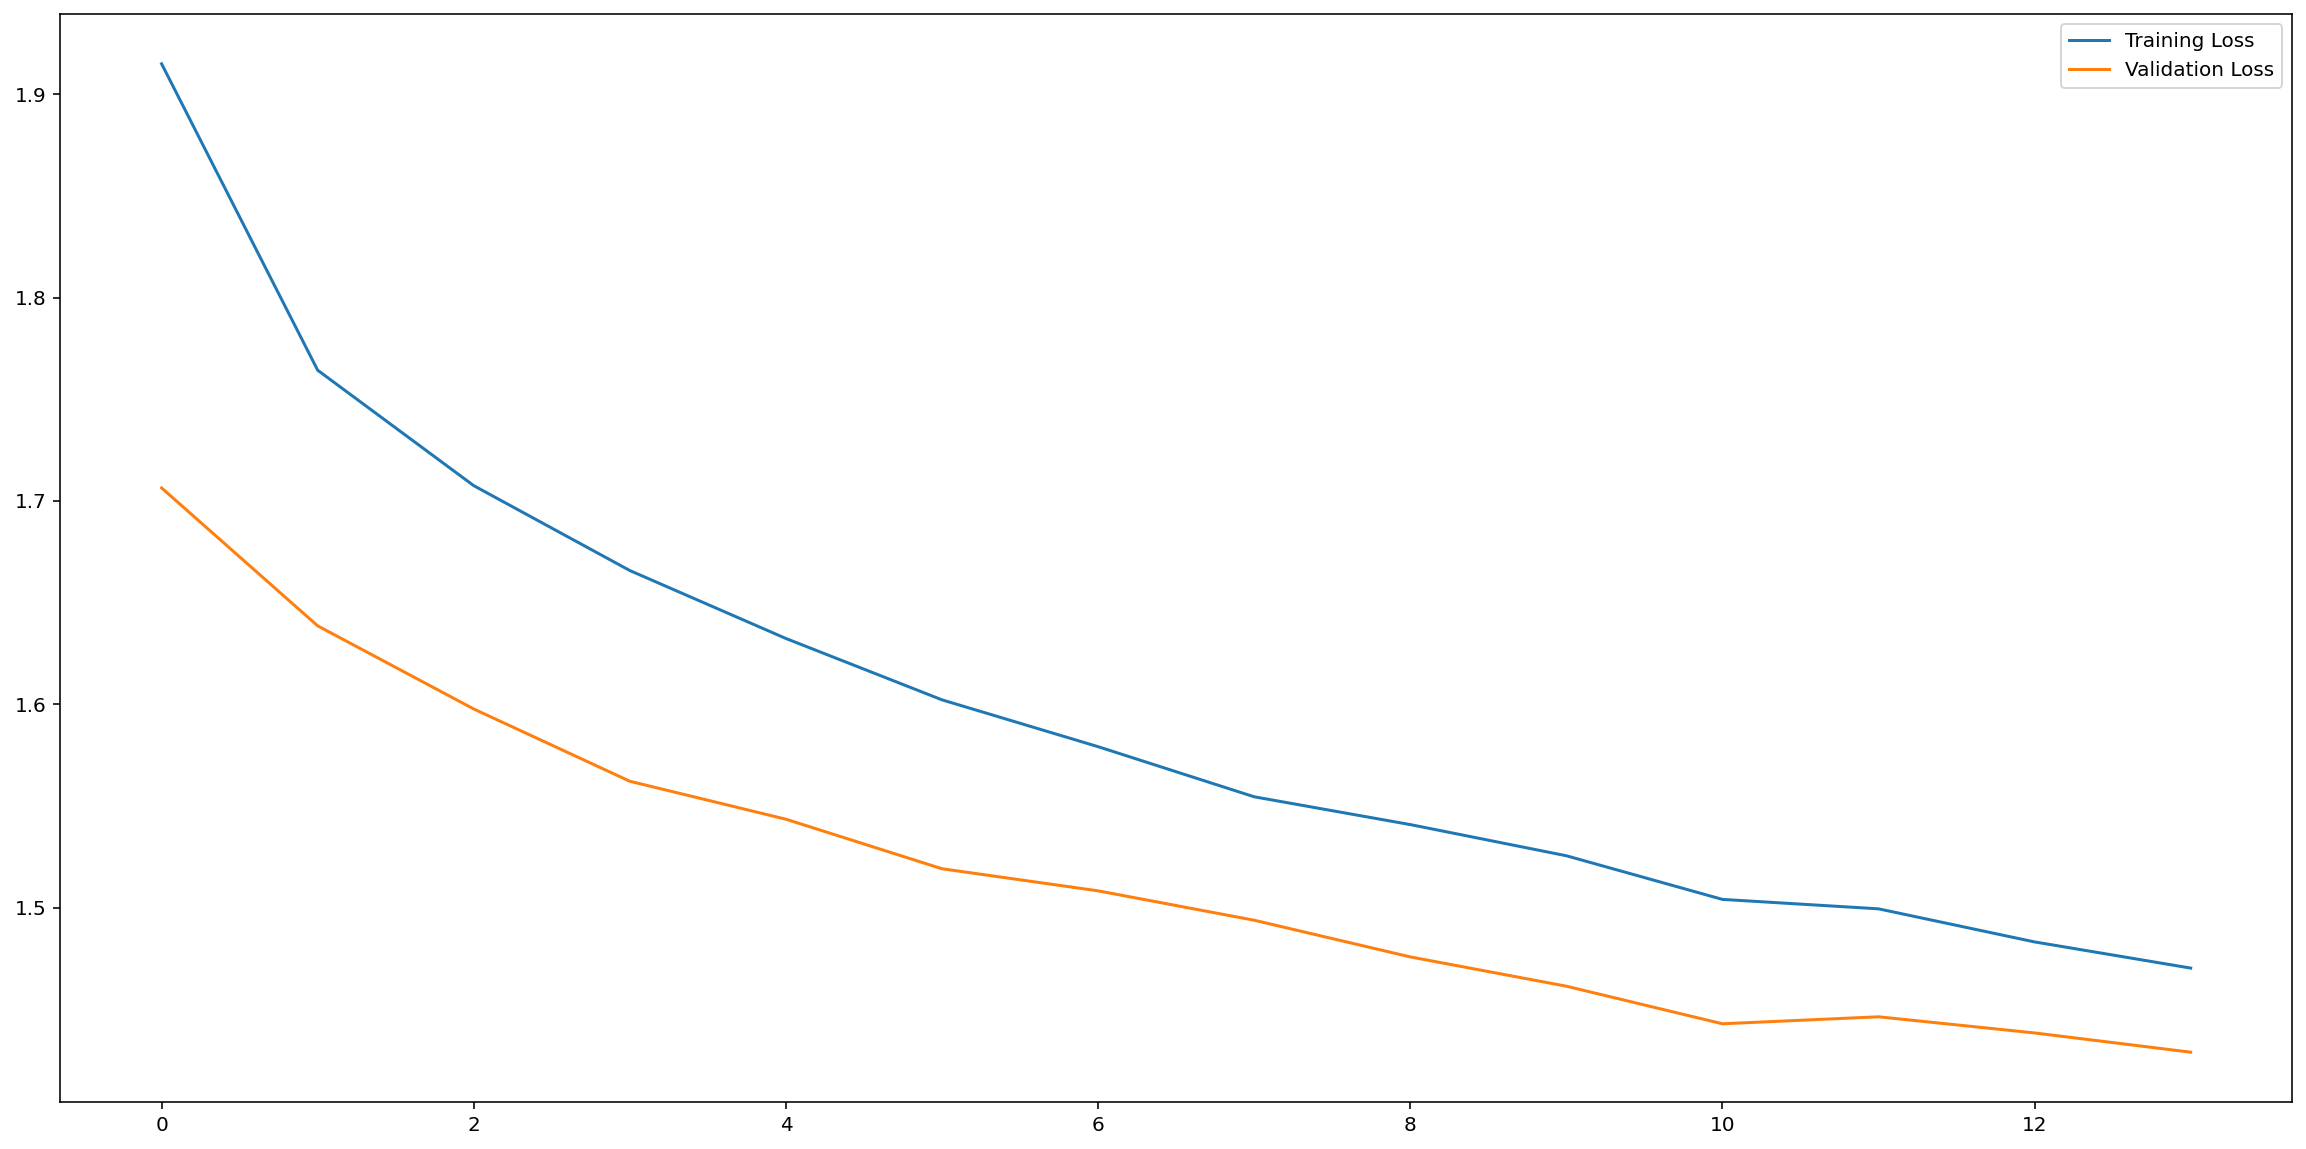

In [51]:

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_MLP_dropout_estop.loss_during_training,label='Training Loss')
ax.plot(my_MLP_dropout_estop.valid_loss_during_training,label='Validation Loss')
ax.legend()
fig.set_facecolor('white')

Ploteamos las mismas dos funciones del MLP junto a las del CNN para compararlas entre sí.

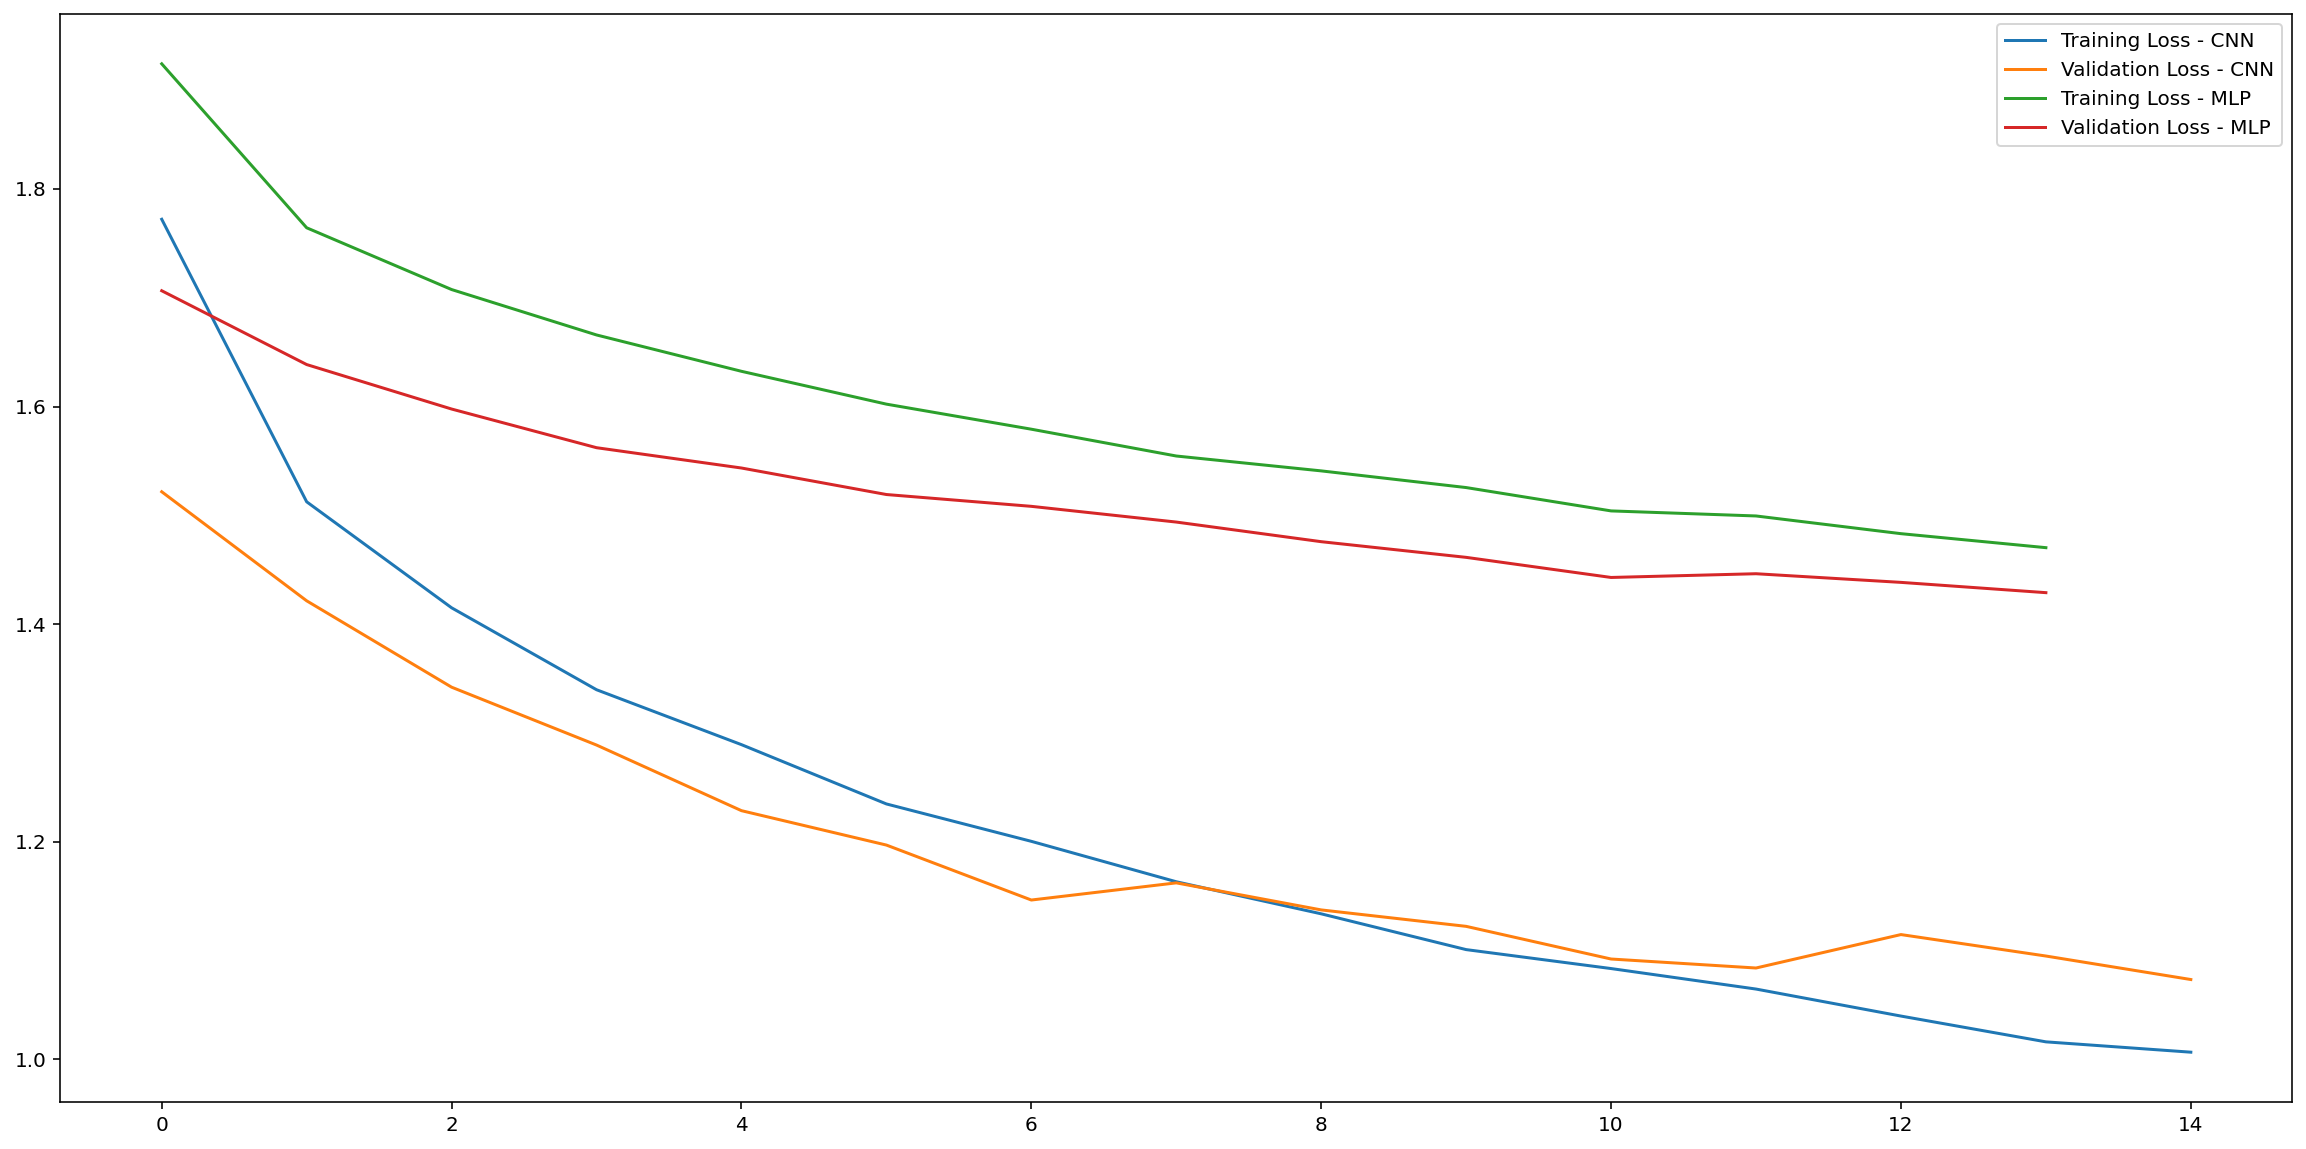

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CNN_GPU_dropout_and_earlystopping.loss_during_training,label='Training Loss - CNN')
ax.plot(my_CNN_GPU_dropout_and_earlystopping.valid_loss_during_training,label='Validation Loss - CNN')
ax.plot(my_MLP_dropout_estop.loss_during_training,label='Training Loss - MLP')
ax.plot(my_MLP_dropout_estop.valid_loss_during_training,label='Validation Loss - MLP')
ax.legend()
fig.set_facecolor('white')

La CNN, con su combinación de dropout y early stopping, muestra una eficacia sobresaliente en comparación con el MLP. Esta superioridad de la CNN probablemente se incrementaría al trabajar con un conjunto de datos que tenga clases más parecidas entre sí. El conjunto actual, con etiquetas muy distintas como autobús, perro y gato, no representa un desafío en este sentido.

La razón de este mejor rendimiento de la CNN se debe a cómo procesa la información. Un MLP básicamente maneja un vector de píxeles y su estrategia de clasificación se basa en la posición específica de estos píxeles. Por lo tanto, si hay variaciones en la imagen como cambios en la posición o en el tamaño de un objeto (como puede ser un número), el MLP puede fallar en la clasificación. En cambio, una CNN no solo se enfoca en los píxeles individuales, sino que analiza la imagen para identificar características distintivas, como formas y texturas, que son independientes de la distribución exacta de los píxeles.

En otras palabras, la CNN supera al MLP en tareas de entrenamiento y validación porque no se limita a la información pixel por pixel; aprovecha la disposición espacial de los píxeles para "entender" mejor la imagen.

En conclusión, para tareas de clasificación de imágenes, un enfoque que combine CNN con MLP será siempre mucho más efectivo y eficiente que usar un MLP por sí solo.